## Importando librerias ##

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import random
from collections import defaultdict, deque
import numpy as np
from scipy.stats import linregress
import time
import tracemalloc

## Items para las colas de prioridas heap

In [2]:
class PriorityQueueItem:
    """
    Clase para encapsular los elementos en la priority_queue
    y definir un criterio de comparación válido para heapq.
    """
    def __init__(self, reduced_cost, path_data):
        self.reduced_cost = tuple(reduced_cost)  # Convertimos la lista a tupla para ser comparable
        self.path_data = path_data  # Diccionario con información del camino

    def __lt__(self, other):
        """ Define la comparación entre dos elementos (criterio lexicográfico). """
        return self.reduced_cost < other.reduced_cost

    def __eq__(self, other):
        """ Define igualdad entre dos elementos. """
        return self.reduced_cost == other.reduced_cost

class PriorityQueueItemNode:
    """
    Clase para encapsular los elementos en la priority_queue en Dijkstra.
    """
    def __init__(self, reduced_cost, node):
        self.reduced_cost = tuple(reduced_cost)  # Convertimos la lista a tupla para ser comparable
        self.node = node  # Nodo asociado

    def __lt__(self, other):
        """ Define la comparación entre dos elementos (criterio lexicográfico). """
        return self.reduced_cost < other.reduced_cost

    def __eq__(self, other):
        """ Define igualdad entre dos elementos. """
        return self.reduced_cost == other.reduced_cost

## Clase del grafo dinámico ##

In [3]:
class DynamicGraph:
    """
    Representación de un grafo dinámico con soporte para aristas unidireccionales o bidireccionales,
    y actualizaciones de costos en tiempo real.
    """
    def __init__(self):
        self.graph = {}  # Diccionario que representa las conexiones {nodo: [(vecino, pesos)]}
        self.modified_edges = set()  # Lista de aristas afectadas por cambios dinámicos


    def add_edge(self, u: str, v: str, time: float, distance: float, safety: float, bidirectional: bool = True):
        """
        Añade una arista al grafo.
        :param u: Nodo de origen.
        :param v: Nodo de destino.
        :param time: Tiempo estimado de viaje para recorrer la arista.
        :param distance: Distancia física de la arista.
        :param safety: Puntaje de seguridad de la arista.
        :param bidirectional: Indica si la arista es bidireccional.
        """

        if u not in self.graph:
            self.graph[u] = []
        if v not in self.graph:
            self.graph[v] = []

        # Agregar arista de u a v
        self.graph[u].append((v, {"time": time, "distance": distance, "safety": safety}))

        if bidirectional:
            # Agregar arista de v a u si es bidireccional
            self.graph[v].append((u, {"time": time, "distance": distance, "safety": safety}))

    def update_edge(self, u: str, v: str, time: float = None, distance: float = None, safety: float = None):
        """
        Actualiza dinámicamente los pesos de una arista.
        :param u: Nodo de origen.
        :param v: Nodo de destino.
        :param time: Nuevo tiempo estimado de viaje (opcional).
        :param distance: Nueva distancia física (opcional).
        :param safety: Nuevo puntaje de seguridad (opcional).
        """
        # Actualizar arista de u a v
        self._update_edge_direction(u, v, time, distance, safety)

        # Si v también tiene una conexión a u, actualizar en esa dirección
        for neighbor, _ in self.graph.get(v, []):
            if neighbor == u:
                self._update_edge_direction(v, u, time, distance, safety)

    def _update_edge_direction(self, u: str, v: str, time: float = None, distance: float = None, safety: float = None):
        """
        Actualiza los valores de una arista en una sola dirección (u -> v).
        """
        for index, (neighbor, costs) in enumerate(self.graph[u]):
            if neighbor == v:
                if time is not None:
                    costs["time"] = time
                if distance is not None:
                    costs["distance"] = distance
                if safety is not None:
                    costs["safety"] = safety
                self.graph[u][index] = (neighbor, costs)
                self.modified_edges.add((u, v))  # Registrar arista modificada

    def get_modified_edges(self):
        """
        Devuelve la lista de aristas que han sido modificadas desde la última actualización.
        """
        return list(self.modified_edges)

    def clear_modified_edges(self):
        """
        Limpia la lista de aristas modificadas.
        """
        self.modified_edges.clear()

    def get_costs(self, u: str, v: str):
        """
        Obtiene los costos de una arista específica.
        :param u: Nodo de origen.
        :param v: Nodo de destino.
        :return: Diccionario con los costos de la arista o None si no existe.
        """
        for neighbor, costs in self.graph.get(u, []):
            if neighbor == v:
                return costs
        return None

    def get_incoming_neighbors(self, node: str):
        """
        Devuelve una lista de nodos que tienen un arco hacia el nodo dado.
        :param node: Nodo para el cual buscar los predecesores.
        :return: Lista de nodos que tienen un arco hacia el nodo dado.
        """
        incoming = []
        for u, edges in self.graph.items():
            for v, _ in edges:
                if v == node:
                    incoming.append(u)
        return incoming


    def get_capacity(self, u: str, v: str):
        """
        Devuelve la capacidad máxima de una arista.
        """
        return self.capacities.get((u, v), float('inf'))  # Si no está definida, asumimos capacidad infinita.

    def display_graph(self):
        """Muestra el grafo en un formato legible."""
        for node, neighbors in self.graph.items():
            print(f"{node}: {[(neighbor, costs) for neighbor, costs in neighbors]}")

    def visualize_graph(self, figsize=(20, 20)):
        """
        Visualiza el grafo utilizando NetworkX y Matplotlib.
        :param figsize: Tamaño de la figura (ancho, alto) en pulgadas.
        """
        # Crear un grafo dirigido (ya que las calles pueden ser unidireccionales)
        G = nx.DiGraph()

        # Agregar nodos y aristas al grafo de NetworkX
        for node, neighbors in self.graph.items():
            for neighbor, weights in neighbors:
                # Agregar una arista con los pesos como etiqueta
                G.add_edge(node, neighbor,
                           label=f'T: {weights["time"]}, D: {weights["distance"]}, S: {weights["safety"]}')

        # Posiciones de los nodos para una disposición agradable en el gráfico
        pos = nx.spring_layout(G, seed=42)  # Disposición automática

        # Ajustar tamaño de la figura
        plt.figure(figsize=figsize)

        # Dibujar nodos y etiquetas de nodos
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
        nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

        # Dibujar aristas
        nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10, edge_color="gray", width=1.0)

        # Dibujar etiquetas de aristas (pesos)
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

        # Mostrar el gráfico
        plt.title("Mapa del Grafo con Pesos (Tiempo, Distancia, Seguridad)", fontsize=16)
        plt.axis("off")
        plt.show()


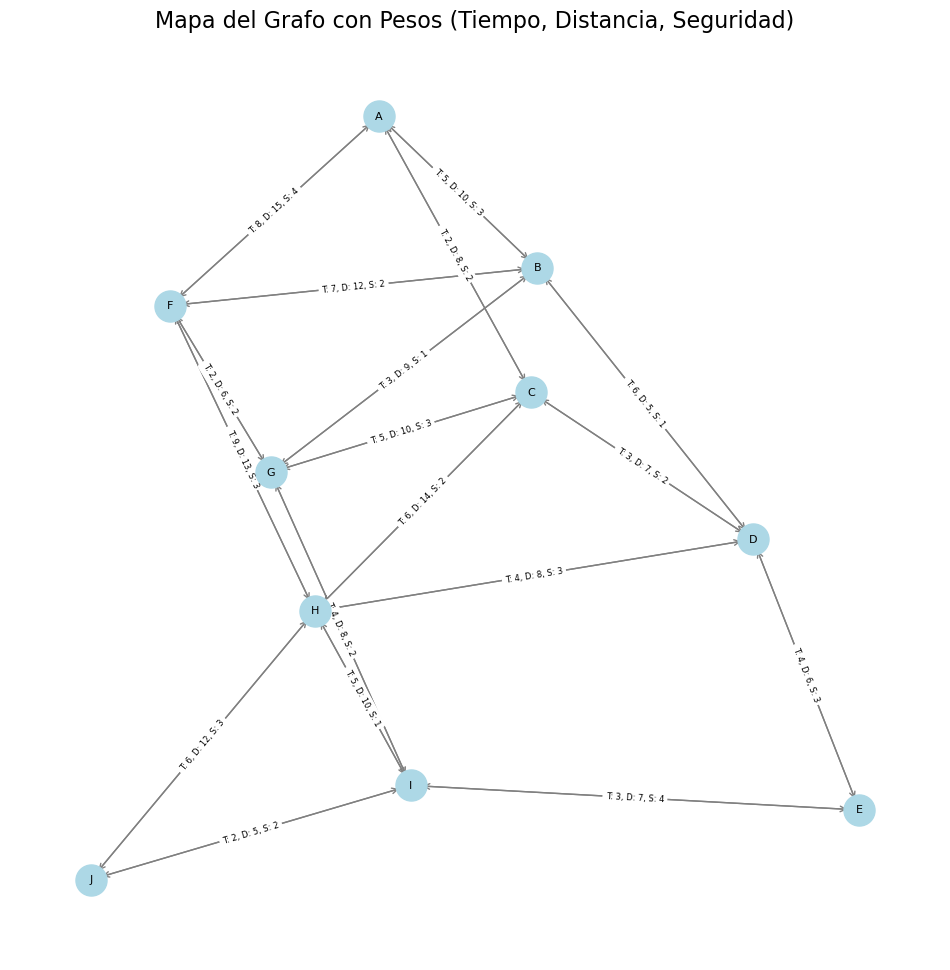

In [4]:
graph = DynamicGraph()
graph.add_edge("A", "B", time=5, distance=10, safety=3)
graph.add_edge("A", "C", time=2, distance=8, safety=2)
graph.add_edge("B", "D", time=6, distance=5, safety=1)
graph.add_edge("C", "D", time=3, distance=7, safety=2)
graph.add_edge("D", "E", time=4, distance=6,safety=3)
graph.add_edge("A" ,"F" ,time=8 ,distance=15 ,safety=4)
graph.add_edge("B" ,"F" ,time=7 ,distance=12 ,safety=2)
graph.add_edge("B" ,"G" ,time=3 ,distance=9 ,safety=1)
graph.add_edge("C" ,"G" ,time=5 ,distance=10,safety=3)
graph.add_edge("C" ,"H" ,time=6,distance=14,safety=2)
graph.add_edge("D" ,"H",time=4,distance=8,safety=3)
graph.add_edge("E" ,"I",time=3,distance=7,safety=4)
graph.add_edge("F" ,"G",time=2,distance=6,safety=2)
graph.add_edge("F" ,"H",time=9,distance=13,safety=3)
graph.add_edge("G" ,"I",time=4,distance=8,safety=2)
graph.add_edge("H" ,"I",time=5,distance=10,safety=1)
graph.add_edge("H" ,"J",time=6,distance = 12,safety = 3)
graph.add_edge("I" ,"J",time = 2,distance = 5,safety = 2)

graph.visualize_graph(figsize=(12, 12))

## Algoritmo TMDA del paper ##

In [5]:
import heapq
from collections import defaultdict

class TMDA:
    """
    Implementación del Algoritmo de Dijkstra Multiobjetivo Dirigido (T-MDA).
    Este algoritmo busca rutas eficientes en un grafo multidimensional para un problema MOSP (Multi-Objective Shortest Path).
    """

    def __init__(self, graph, dimensions, source, target, debug_track = False):
        """
        Inicializa el T-MDA.

        :param graph: Instancia de la clase DynamicGraph que representa el grafo dirigido.
        :param dimensions: Lista de propiedades a optimizar (ej., ["time", "distance", "safety"]).
        :param source: Nodo fuente (s).
        :param target: Nodo objetivo (t).
        :param heuristic: Diccionario de heurísticas por nodo {nodo: [h1, h2, ..., hd]}.
        :param dominance_bound: Vector de cota de dominancia [δ1, δ2, ..., δd].
        :param debug_track : ....
        """
        self.graph = graph  # Grafo dinámico proporcionado como entrada.
        self.dimensions = dimensions  # Dimensiones de optimización, como tiempo, distancia, seguridad, etc.
        self.source = source  # Nodo de inicio del recorrido.
        self.target = target  # Nodo objetivo del recorrido.
        self.debug_track = debug_track
        self.heuristic, self.dominance_bound = self.compute_heuristic_and_dominance_bound() # Heurística utilizada para guiar la búsqueda y Cota de dominancia para podar caminos ineficientes.



        # Cola de prioridad para manejar caminos explorados, ordenada por costos reducidos (lexicográficamente).
        self.priority_queue = []

        # Diccionario que almacena caminos eficientes desde el origen a cada nodo (P_{sv}).
        self.pareto_front = defaultdict(list)

        # Diccionario que almacena caminos explorados pero no eficientes (NQP_{uv}).
        self.non_queue_paths = defaultdict(list)
        self.show_debug_info(f"\n--- Inicialización de TMDA ---")
        self.show_debug_info(f"Source: {self.source}, Target: {self.target}, Dimensiones: {self.dimensions}")
        self.show_debug_info(f"Heurística inicial: {self.heuristic}")
        self.show_debug_info(f"Cota de dominancia: {self.dominance_bound}")

    def dijkstra_lexicographic(self, order):
        """
        Ejecuta una consulta léxica de Dijkstra para calcular caminos más cortos según un orden dado.
        :param graph: Instancia de DynamicGraph que representa el grafo dirigido.
        :param dimensions: Lista de propiedades a optimizar (ej., ["time", "distance", "safety"]).
        :param target: Nodo objetivo (t).
        :param order: Orden de prioridades para las dimensiones (ej., [0, 1, 2]).
        :return: Diccionario con costos de caminos más cortos desde cada nodo al objetivo según el orden.
        """

        self.show_debug_info(f"\n--- Ejecutando dijkstra_lexicographic ---")
        self.show_debug_info(f"Dimensiones: {self.dimensions}")
        self.show_debug_info(f"Orden: {order}")
        self.show_debug_info(f"Target: {self.target}")

        # Creamos un grafo invertido para facilitar la búsqueda desde el nodo objetivo hacia todos los demás nodos.
        reverse_graph = defaultdict(list)
        for node in self.graph.graph:
            for neighbor, properties in self.graph.graph[node]:
                reverse_graph[neighbor].append((node, properties))

        self.show_debug_info("Grafo invertido construido.")

        # Inicializamos la cola de prioridad. Contendrá los nodos a procesar, ordenados por costos acumulados.
        priority_queue = []
        # Diccionario para almacenar los costos más cortos encontrados hasta ahora para cada nodo.
        shortest_paths = {node: [float('inf')] * len(self.dimensions) for node in self.graph.graph}
        shortest_paths[self.target] = [0] * len(self.dimensions)  # El costo al nodo objetivo desde sí mismo es cero.

        # Insertamos el nodo objetivo en la cola de prioridad con costos iniciales en cero.
        heapq.heappush(priority_queue, (tuple([0] * len(self.dimensions)), self.target))
        self.show_debug_info(f"Inicialización completa. Cola de prioridad: {priority_queue}")

        # Bucle principal de Dijkstra
        while priority_queue:
            # Extraemos el nodo con el menor costo acumulado (según el orden léxico dado).
            current_cost, node = heapq.heappop(priority_queue)
            self.show_debug_info(f"\nProcesando nodo {node} con costo actual: {current_cost}")

            # Procesamos los nodos vecinos del nodo actual (en el grafo invertido).
            for neighbor, properties in reverse_graph[node]:
                # Calculamos los nuevos costos acumulados basados en las prioridades especificadas en el orden.
                new_cost = [
                    current_cost[i] + properties[self.dimensions[order[i]]]
                    for i in range(len(self.dimensions))
                ]
                self.show_debug_info(f"  Analizando vecino {neighbor}, nuevo costo: {new_cost}")

                # Verificamos si los nuevos costos mejoran los costos almacenados para el nodo vecino.
                if all(new_cost[i] < shortest_paths[neighbor][i] for i in range(len(self.dimensions))):
                    self.show_debug_info(f"  Nuevo costo para {neighbor} mejora los existentes: {shortest_paths[neighbor]} -> {new_cost}")
                    # Si encontramos un mejor camino, actualizamos los costos y añadimos el vecino a la cola.
                    shortest_paths[neighbor] = new_cost
                    heapq.heappush(priority_queue, (tuple(new_cost), neighbor))

        self.show_debug_info(f"\n--- Resultados de dijkstra_lexicographic ---")
        self.show_debug_info(shortest_paths)
        # Devolvemos el diccionario con los costos más cortos encontrados.
        return shortest_paths


    def compute_heuristic_and_dominance_bound(self):
        """
        Calcula la heurística y la cota de dominancia para una instancia del problema MOSP.
        :param graph: Instancia de DynamicGraph que representa el grafo dirigido.
        :param dimensions: Lista de propiedades a optimizar (ej., ["time", "distance", "safety"]).
        :param source: Nodo fuente (s).
        :param target: Nodo objetivo (t).
        :return: Diccionario de heurísticas y vector de cota de dominancia.
        """
        self.show_debug_info(f"\n--- Calculando heurística y cota de dominancia ---")
        self.show_debug_info(f"Source: {self.source}, Target: {self.target}, Dimensiones: {self.dimensions}")

        # Número de dimensiones (d) para los costos.
        d = len(self.dimensions)

        # En este ejemplo, asumimos un único orden por prioridad: las dimensiones se ordenan en su índice natural.
        orders = [list(range(d))]  # Puede ampliarse para manejar múltiples permutaciones de órdenes.

        # Diccionario para almacenar los puntos ideales de cada nodo.
        ideal_points = {}

        # Ejecutamos consultas léxicas para calcular los puntos ideales utilizando cada orden.
        for order in orders:
            self.show_debug_info(f"\nRealizando consulta léxica para orden: {order}")
            # Llamamos a Dijkstra léxico para obtener los costos más cortos desde cada nodo al objetivo.
            result = self.dijkstra_lexicographic(order)

            # Actualizamos los puntos ideales de cada nodo.
            for node, cost in result.items():
                self.show_debug_info(f"  Nodo: {node}, Costo calculado: {cost}")
                if node not in ideal_points:
                    # Si es la primera vez que procesamos el nodo, almacenamos los costos directamente.
                    ideal_points[node] = cost
                else:
                    # Si ya hemos calculado puntos ideales para este nodo, tomamos los mínimos por componente.
                    ideal_points[node] = [
                        min(ideal_points[node][i], cost[i]) for i in range(d)
                    ]
                self.show_debug_info(f"  Puntos ideales para {node}: {ideal_points[node]}")

        # Calculamos la heurística para cada nodo, utilizando los puntos ideales calculados.
        heuristic = {node: ideal_points[node] for node in self.graph.graph}
        self.show_debug_info(f"Heurística calculada: {heuristic}")

        # Calculamos la cota de dominancia (dominance_bound) basada en los puntos ideales del nodo fuente.
        dominance_bound = [
            max(ideal_points[self.source][i] for order in orders) + 1e-5  # Añadimos un epsilon pequeño para asegurar dominancia estricta.
            for i in range(d)
        ]
        self.show_debug_info(f"Cota de dominancia calculada: {dominance_bound}")
        # Devolvemos el diccionario de heurísticas y la cota de dominancia.
        return heuristic, dominance_bound


    def dominates(self, vec1, vec2):
        """
        Comprueba si un vector vec1 domina a otro vector vec2.

        :param vec1: Primer vector.
        :param vec2: Segundo vector.
        :return: True si vec1 domina a vec2, False en caso contrario.
        """
        # vec1 domina a vec2 si todos los componentes de vec1 son menores o iguales que los de vec2,
        # y al menos uno de los componentes de vec1 es estrictamente menor que el correspondiente de vec2.
        result = all(x <= y for x, y in zip(vec1, vec2)) and any(x < y for x, y in zip(vec1, vec2))
        self.show_debug_info(f"Comprobando dominancia: {vec1} domina a {vec2} -> {result}")
        return result

    def extend_path(self, path, edge):
        """
        Extiende un camino actual mediante un arco.

        :param path: Camino actual (diccionario con 'path', 'cost', 'reduced_cost').
        :param edge: Arco (u, v) que extiende el camino.
        :return: Diccionario que representa el nuevo camino extendido.
        """
        self.show_debug_info(f"Extender camino: {path['path']} por arista {edge}")
        u, v = edge  # Desempaqueta el arco (u -> v).
        arc_costs = self.graph.get_costs(u, v)  # Obtiene los costos del arco (u, v).

        # Calcula los nuevos costos acumulativos sumando los costos del arco.
        new_cost = [path['cost'][i] + arc_costs[self.dimensions[i]] for i in range(len(self.dimensions))]

        # Calcula los costos reducidos añadiendo la heurística del nodo destino.
        new_cost_reduced = [new_cost[i] + self.heuristic[v][i] for i in range(len(self.dimensions))]

        new_path = {
            'path': path['path'] + [v],  # Añade el nodo destino al camino.
            'cost': new_cost,  # Costos acumulativos del nuevo camino.
            'reduced_cost': new_cost_reduced  # Costos reducidos del nuevo camino.
        }
        # Devuelve el nuevo camino extendido.
        self.show_debug_info(f"Nuevo camino extendido: {new_path}")
        return new_path

    def propagate(self, current_path, edge):
        """
        Propaga un camino actual hacia un nodo vecino.

        :param current_path: Camino actual (diccionario con 'path', 'cost', 'reduced_cost').
        :param edge: Arco (u, v) que extiende el camino.
        """
        self.show_debug_info(f"\nPropagando camino {current_path['path']} hacia {edge[1]}")
        # Genera un nuevo camino extendido usando el arco proporcionado.
        new_path = self.extend_path(current_path, edge)
        reduced_cost = new_path['reduced_cost']  # Extrae los costos reducidos del nuevo camino.

        # Poda: descarta el camino si está dominado por la cota de dominancia o por caminos eficientes.
        if self.dominates(self.dominance_bound, reduced_cost) or any(
                self.dominates(permanent['reduced_cost'], reduced_cost) for permanent in self.pareto_front[edge[1]]):
            self.show_debug_info(f"  Camino descartado por cota de dominancia o dominancia de eficientes.")
            return

        # Verifica si ya existe un camino similar en la cola de prioridad.
        for _, path in self.priority_queue:
            if path['path'][-1] == edge[1]:  # Compara los nodos finales de ambos caminos.
                # Si el nuevo camino es mejor, actualiza el existente.
                if self.dominates(reduced_cost, path['reduced_cost']):
                    path['reduced_cost'] = reduced_cost
                    path['path'] = new_path['path']
                    path['cost'] = new_path['cost']
                    heapq.heapify(self.priority_queue)  # Reordena la cola de prioridad.
                return

        # Si no hay conflictos, añade el nuevo camino a la cola de prioridad.
        heapq.heappush(self.priority_queue, (tuple(reduced_cost), new_path))
        self.show_debug_info(f"  Camino agregado a la cola de prioridad: {new_path}")

    def next_queue_path(self, node):
        """
        Encuentra el siguiente camino de cola para un nodo.

        :param node: Nodo actual.
        :return: Camino de cola para el nodo o None si no hay candidatos válidos.
        """
        self.show_debug_info(f"\nBuscando siguiente camino de cola para el nodo {node}")
        candidates = []
        # Recolecta caminos explorados pero no eficientes hacia el nodo.
        for pred in self.graph.get_incoming_neighbors(node):
            candidates.extend(self.non_queue_paths[(pred, node)])

        # Ordena los caminos candidatos por costos reducidos.
        candidates = sorted(candidates, key=lambda p: tuple(p['reduced_cost']))

        # Encuentra un camino no dominado por otros candidatos.
        for candidate in candidates:
            if not self.dominates(self.dominance_bound, candidate['reduced_cost']) and not any(
                    self.dominates(permanent['cost'], candidate['cost']) for permanent in self.pareto_front[node]):
                self.show_debug_info(f"  Camino seleccionado como siguiente de cola: {candidate}")
                return candidate  # Devuelve el camino de cola encontrado.
        self.show_debug_info("  No se encontró un camino válido.")
        return None  # No se encontró un camino válido.

    def run(self):
        """
        Ejecuta el Algoritmo T-MDA.

        :return: Lista de caminos eficientes desde el origen al objetivo.
        """
        self.show_debug_info("\n--- Ejecutando TMDA ---")
        # Inicializa el camino desde el nodo fuente con costos iniciales en cero.
        initial_path = {
            'path': [self.source],  # El camino inicial comienza en el nodo fuente.
            'cost': [0] * len(self.dimensions),  # Costos iniciales son cero para todas las dimensiones.
            'reduced_cost': self.heuristic[self.source]  # Los costos reducidos iniciales son la heurística del nodo fuente.
        }

        # Añade el camino inicial a la cola de prioridad.
        heapq.heappush(self.priority_queue, (tuple(initial_path['reduced_cost']), initial_path))
        self.show_debug_info(f"Camino inicial insertado en la cola de prioridad: {initial_path}")

        # Procesa caminos hasta que la cola de prioridad esté vacía.
        while self.priority_queue:
            _, current_path = heapq.heappop(self.priority_queue)  # Extrae el camino con menor costo reducido.
            node = current_path['path'][-1]  # Nodo destino del camino extraído.
            self.show_debug_info(f"\nProcesando camino: {current_path['path']}")
            # Añade el camino extraído a los eficientes del nodo correspondiente.
            self.pareto_front[node].append(current_path)
            self.show_debug_info(f"Camino añadido a eficientes para el nodo {node}: {current_path}")
            # Busca un nuevo camino de cola para el nodo actual.
            new_queue_path = self.next_queue_path(node)
            if new_queue_path:
                heapq.heappush(self.priority_queue, (tuple(new_queue_path['reduced_cost']), new_queue_path))

            # Propaga caminos desde el nodo actual hacia sus vecinos.
            if node != self.target:  # No propagar si ya se alcanzó el objetivo.
                for neighbor, _ in self.graph.graph.get(node, []):
                    self.propagate(current_path, (node, neighbor))

        # Devuelve los caminos eficientes hacia el nodo objetivo.
        self.show_debug_info(f"\n--- Caminos eficientes encontrados (frente de Pareto) ---")
        for path in self.pareto_front:
            for path1 in self.pareto_front[path]:
                self.show_debug_info(path1['path'])
        self.show_debug_info(self.pareto_front[self.target])
        """print("*********************")
        print(self.non_queue_paths)"""
        return self.pareto_front[self.target]

    def select_best_path(self):

        # Heurística para seleccionar el mejor nodo del frente de Pareto
        best_path = None
        best_score = float('inf')
        for path in self.pareto_front[self.target]:
            # Ponderación lineal: combinar los criterios con pesos
            score = sum(path['cost'])
            if score < best_score:
                best_score = score
                best_path = path

        return best_path


    def show_debug_info(self, msg):
        if (self.debug_track):
            print(msg)

In [6]:
# Definir las dimensiones y nodos de inicio/fin
dimensions = ["time", "distance", "safety"]
source = "A"
target = "J"


# Ejecutar el algoritmo T-MDA
tmda = TMDA(
    graph=graph,
    dimensions=dimensions,
    source=source,
    target=target,
    debug_track = True
)
result = tmda.run()

# Imprimir resultados
print("Rutas eficientes encontradas desde", source, "hasta", target)
for path in result:
    print(f"Ruta: {path['path']}, Costo: {path['cost']}")

best_path = tmda.select_best_path()
print("Ruta mas eficiente encontrada desde", source, "hasta", target)
print(f"Ruta: {best_path['path']}, Costo: {best_path['cost']}")


--- Calculando heurística y cota de dominancia ---
Source: A, Target: J, Dimensiones: ['time', 'distance', 'safety']

Realizando consulta léxica para orden: [0, 1, 2]

--- Ejecutando dijkstra_lexicographic ---
Dimensiones: ['time', 'distance', 'safety']
Orden: [0, 1, 2]
Target: J
Grafo invertido construido.
Inicialización completa. Cola de prioridad: [((0, 0, 0), 'J')]

Procesando nodo J con costo actual: (0, 0, 0)
  Analizando vecino H, nuevo costo: [6, 12, 3]
  Nuevo costo para H mejora los existentes: [inf, inf, inf] -> [6, 12, 3]
  Analizando vecino I, nuevo costo: [2, 5, 2]
  Nuevo costo para I mejora los existentes: [inf, inf, inf] -> [2, 5, 2]

Procesando nodo I con costo actual: (2, 5, 2)
  Analizando vecino E, nuevo costo: [5, 12, 6]
  Nuevo costo para E mejora los existentes: [inf, inf, inf] -> [5, 12, 6]
  Analizando vecino G, nuevo costo: [6, 13, 4]
  Nuevo costo para G mejora los existentes: [inf, inf, inf] -> [6, 13, 4]
  Analizando vecino H, nuevo costo: [7, 15, 3]
  An

## Actualización dinámica de las aristas del grafo ##

In [7]:
class DynamicEdgeUpdater:
    """
    Clase para simular actualizaciones dinámicas en los pesos de las aristas de un grafo.
    """
    def __init__(self, graph, max_safety_variation=2, max_time_variation_factor=1.2):
        """
        Inicializa el simulador de actualizaciones dinámicas de las aristas.

        :param graph: Instancia del grafo dinámico (DynamicGraph).
        :param max_safety_variation: Valor máximo en que puede variar el safety de una arista.
        :param max_time_variation_factor: Factor máximo en que puede variar el tiempo cuando safety cambia.
        """
        self.graph = graph  # Grafo dinámico
        self.max_safety_variation = max_safety_variation
        self.max_time_variation_factor = max_time_variation_factor

    def update_weights(self, current_path):
        """
        Actualiza dinámicamente los pesos de las aristas en el grafo.

        :param current_path: El camino actual por el que se está navegando (lista de nodos).
        :return: Lista de aristas que fueron actualizadas [(u, v, {"time": x, "safety": y})].
        """
        updated_edges = []  # Lista de actualizaciones realizadas

        # Iterar sobre las aristas del camino actual
        for i in range(len(current_path) - 1):
            u, v = current_path[i], current_path[i + 1]

            # 50% de probabilidad de modificar los pesos de esta arista
            if random.random() < 0.5:
                # Obtener los pesos actuales de la arista
                edge_costs = self.graph.get_costs(u, v)
                if edge_costs is None:
                    continue  # Si no hay arista, pasar al siguiente par de nodos

                # Variación aleatoria en safety
                safety_variation = random.randint(-self.max_safety_variation, self.max_safety_variation)
                new_safety = max(1, edge_costs["safety"] + safety_variation)  # Safety no puede ser menor que 1

                # Si safety aumenta, el tiempo también aumenta (relación inversa con velocidad)
                if safety_variation > 0:
                    new_time = edge_costs["time"] * (1 + (safety_variation / 10.0))  # Incremento proporcional
                else:
                    new_time = edge_costs["time"] * (1 - abs(safety_variation) / 10.0)  # Reducción proporcional

                # Asegurar que el tiempo no sea menor a 1
                new_time = max(1, new_time)

                # Crear los nuevos costos para la arista
                updated_weights = {
                    "time": new_time,
                    "distance": edge_costs["distance"],  # La distancia no varía
                    "safety": new_safety
                }

                # Actualizar los pesos en el grafo
                self.graph.update_edge(u, v, **updated_weights)

                # Registrar la actualización
                updated_edges.append((u, v, updated_weights))

        """if updated_edges:
            print("Actualizaciones realizadas en las aristas:")
            for edge in updated_edges:
                print(f"  {edge[0]} -> {edge[1]}: {edge[2]}")
        """
        return updated_edges


## Algoritmo TMDA dinámico ##

In [8]:
class DynamicTMDA:
    """
    Implementación del Algoritmo de Dijkstra Multiobjetivo Dirigido (T-MDA).
    Este algoritmo busca rutas eficientes en un grafo multidimensional para un problema MOSP (Multi-Objective Shortest Path).
    """

    def __init__(self, graph, dimensions, source, target, edge_updater, debug_track = False):
        """
        Inicializa el T-MDA.

        :param graph: Instancia de la clase DynamicGraph que representa el grafo dirigido.
        :param dimensions: Lista de propiedades a optimizar (ej., ["time", "distance", "safety"]).
        :param source: Nodo fuente (s).
        :param target: Nodo objetivo (t).
        :param heuristic: Diccionario de heurísticas por nodo {nodo: [h1, h2, ..., hd]}.
        :param dominance_bound: Vector de cota de dominancia [δ1, δ2, ..., δd].
        :param debug_track : ....
        """
        self.graph = graph  # Grafo dinámico proporcionado como entrada.
        # Crear dos listas separadas


        self.dimensions = [item[0] for item in dimensions]  # Dimensiones de optimización, como tiempo, distancia, seguridad, etc.
        self.dim_preferences = [item[1] for item in dimensions] # Preferencias de las dimenciones
        self.source = source  # Nodo de inicio del recorrido.
        self.target = target  # Nodo objetivo del recorrido.
        self.debug_track = debug_track
        self.edge_updater = edge_updater
        self.heuristic, self.dominance_bound = self.compute_heuristic_and_dominance_bound() # Heurística utilizada para guiar la búsqueda y Cota de dominancia para podar caminos ineficientes.

        # Cola de prioridad para manejar caminos explorados, ordenada por costos reducidos (lexicográficamente).
        self.priority_queue = []

        # Diccionario que almacena caminos eficientes desde el origen a cada nodo (P_{sv}).
        self.pareto_front = defaultdict(list)

        # Historial de cambios en pesos (clave: arista, valor: deque de cambios recientes)
        self.weight_history = defaultdict(lambda: defaultdict(lambda: deque(maxlen=10)))  # Almacena hasta 10 valores previos por dimensión

        # Diccionario que almacena caminos explorados pero no eficientes (NQP_{uv}).
        self.non_queue_paths = defaultdict(list)

        self.complete_path = {}
        self.start_path = {}
        self.recalculate_count = 0
        self.modified_edges_count = 0
        self.iterations_count = 0

        self.show_debug_info(f"\n--- Inicialización de TMDA ---")
        self.show_debug_info(f"Source: {self.source}, Target: {self.target}, Dimensiones: {self.dimensions}")
        self.show_debug_info(f"Heurística inicial: {self.heuristic}")
        self.show_debug_info(f"Cota de dominancia: {self.dominance_bound}")



    def dijkstra_lexicographic(self, order):
        """
        Ejecuta una consulta léxica de Dijkstra para calcular caminos más cortos según un orden dado.

        :param order: Orden de prioridades para las dimensiones (ej., [0, 1, 2]).
        :return: Diccionario con costos de caminos más cortos desde cada nodo al objetivo según el orden.
        """

        self.show_debug_info(f"\n--- Ejecutando dijkstra_lexicographic ---")
        self.show_debug_info(f"Dimensiones: {self.dimensions}")
        self.show_debug_info(f"Orden: {order}")
        self.show_debug_info(f"Target: {self.target}")

        # Creamos un grafo invertido para facilitar la búsqueda desde el nodo objetivo hacia todos los demás nodos.
        reverse_graph = defaultdict(list)
        for node in self.graph.graph:
            for neighbor, properties in self.graph.graph[node]:
                reverse_graph[neighbor].append((node, properties))

        self.show_debug_info("Grafo invertido construido.")

        # Inicializamos la cola de prioridad con objetos `PriorityQueueItemNode`
        priority_queue = []
        # Diccionario para almacenar los costos más cortos encontrados hasta ahora para cada nodo.
        shortest_paths = {node: [float('inf')] * len(self.dimensions) for node in self.graph.graph}
        shortest_paths[self.target] = [0] * len(self.dimensions)  # El costo al nodo objetivo desde sí mismo es cero.

        # Insertamos el nodo objetivo en la cola de prioridad con costos iniciales en cero.
        heapq.heappush(priority_queue, PriorityQueueItemNode([0] * len(self.dimensions), self.target))
        self.show_debug_info(f"Inicialización completa. Cola de prioridad: {priority_queue}")

        # Bucle principal de Dijkstra
        while priority_queue:
            # Extraemos el nodo con el menor costo acumulado (según el orden léxico dado).
            current_item = heapq.heappop(priority_queue)
            current_cost = list(current_item.reduced_cost)
            node = current_item.node  # Corregido: Ahora `node` existe en `PriorityQueueItemNode`

            self.show_debug_info(f"\nProcesando nodo {node} con costo actual: {current_cost}")

            # Procesamos los nodos vecinos del nodo actual (en el grafo invertido).
            for neighbor, properties in reverse_graph[node]:
                # Calculamos los nuevos costos acumulados basados en las prioridades especificadas en el orden.
                new_cost = [
                    current_cost[i] + properties[self.dimensions[order[i]]] * self.dim_preferences[i]
                    for i in range(len(self.dimensions))
                ]

                self.show_debug_info(f"  Analizando vecino {neighbor}, nuevo costo: {new_cost}")

                # Verificamos si los nuevos costos mejoran los costos almacenados para el nodo vecino.
                if all(new_cost[i] < shortest_paths[neighbor][i] for i in range(len(self.dimensions))):
                    self.show_debug_info(f"  Nuevo costo para {neighbor} mejora los existentes: {shortest_paths[neighbor]} -> {new_cost}")
                    # Si encontramos un mejor camino, actualizamos los costos y añadimos el vecino a la cola.
                    shortest_paths[neighbor] = new_cost
                    heapq.heappush(priority_queue, PriorityQueueItemNode(new_cost, neighbor))  # Ahora `neighbor` se almacena en `node`

        self.show_debug_info(f"\n--- Resultados de dijkstra_lexicographic ---")
        self.show_debug_info(shortest_paths)
        # Devolvemos el diccionario con los costos más cortos encontrados.
        return shortest_paths



    def compute_heuristic_and_dominance_bound(self):
        """
        Calcula la heurística y la cota de dominancia para una instancia del problema MOSP.
        :param graph: Instancia de DynamicGraph que representa el grafo dirigido.
        :param dimensions: Lista de propiedades a optimizar (ej., ["time", "distance", "safety"]).
        :param source: Nodo fuente (s).
        :param target: Nodo objetivo (t).
        :return: Diccionario de heurísticas y vector de cota de dominancia.
        """
        self.show_debug_info(f"\n--- Calculando heurística y cota de dominancia ---")
        self.show_debug_info(f"Source: {self.source}, Target: {self.target}, Dimensiones: {self.dimensions}")

        # Número de dimensiones (d) para los costos.
        d = len(self.dimensions)

        # En este ejemplo, asumimos un único orden por prioridad: las dimensiones se ordenan en su índice natural.
        orders = [list(range(d))]  # Puede ampliarse para manejar múltiples permutaciones de órdenes.

        # Diccionario para almacenar los puntos ideales de cada nodo.
        ideal_points = {}

        # Ejecutamos consultas léxicas para calcular los puntos ideales utilizando cada orden.
        for order in orders:
            self.show_debug_info(f"\nRealizando consulta léxica para orden: {order}")
            # Llamamos a Dijkstra léxico para obtener los costos más cortos desde cada nodo al objetivo.
            result = self.dijkstra_lexicographic(order)

            # Actualizamos los puntos ideales de cada nodo.
            for node, cost in result.items():
                self.show_debug_info(f"  Nodo: {node}, Costo calculado: {cost}")
                if node not in ideal_points:
                    # Si es la primera vez que procesamos el nodo, almacenamos los costos directamente.
                    ideal_points[node] = cost
                else:
                    # Si ya hemos calculado puntos ideales para este nodo, tomamos los mínimos por componente.
                    ideal_points[node] = [
                        min(ideal_points[node][i], cost[i]) for i in range(d)
                    ]
                self.show_debug_info(f"  Puntos ideales para {node}: {ideal_points[node]}")

        # Calculamos la heurística para cada nodo, utilizando los puntos ideales calculados.
        heuristic = {node: ideal_points[node] for node in self.graph.graph}
        self.show_debug_info(f"Heurística calculada: {heuristic}")

        # Calculamos la cota de dominancia (dominance_bound) basada en los puntos ideales del nodo fuente.
        dominance_bound = [
            max(ideal_points[self.source][i] for order in orders) + 1e-5  # Añadimos un epsilon pequeño para asegurar dominancia estricta.
            for i in range(d)
        ]
        self.show_debug_info(f"Cota de dominancia calculada: {dominance_bound}")
        # Devolvemos el diccionario de heurísticas y la cota de dominancia.
        return heuristic, dominance_bound


    def dominates(self, vec1, vec2):
        """
        Comprueba si un vector vec1 domina a otro vector vec2.

        :param vec1: Primer vector.
        :param vec2: Segundo vector.
        :return: True si vec1 domina a vec2, False en caso contrario.
        """
        # vec1 domina a vec2 si todos los componentes de vec1 son menores o iguales que los de vec2,
        # y al menos uno de los componentes de vec1 es estrictamente menor que el correspondiente de vec2.
        result = all(x <= y for x, y in zip(vec1, vec2)) and any(x < y for x, y in zip(vec1, vec2))
        self.show_debug_info(f"Comprobando dominancia: {vec1} domina a {vec2} -> {result}")
        return result

    def extend_path(self, path, edge):
        """
        Extiende un camino actual mediante un arco.

        :param path: Camino actual (diccionario con 'path', 'cost', 'reduced_cost').
        :param edge: Arco (u, v) que extiende el camino.
        :return: Diccionario que representa el nuevo camino extendido.
        """
        self.show_debug_info(f"Extender camino: {path['path']} por arista {edge}")
        u, v = edge  # Desempaqueta el arco (u -> v).
        arc_costs = self.graph.get_costs(u, v)  # Obtiene los costos del arco (u, v).

        # Calcula los nuevos costos acumulativos sumando los costos del arco.
        new_cost = [path['cost'][i] + arc_costs[self.dimensions[i]] * self.dim_preferences[i] for i in range(len(self.dimensions))]


        # Calcula los costos reducidos añadiendo la heurística del nodo destino.
        new_cost_reduced = [new_cost[i] + self.heuristic[v][i] * self.dim_preferences[i] for i in range(len(self.dimensions))]

        new_path = {
            'path': path['path'] + [v],  # Añade el nodo destino al camino.
            'cost': new_cost,  # Costos acumulativos del nuevo camino.
            'reduced_cost': new_cost_reduced  # Costos reducidos del nuevo camino.
        }
        # Devuelve el nuevo camino extendido.
        self.show_debug_info(f"Nuevo camino extendido: {new_path}")
        return new_path

    def propagate(self, current_path, edge):
        """
        Propaga un camino actual hacia un nodo vecino.

        :param current_path: Camino actual (diccionario con 'path', 'cost', 'reduced_cost').
        :param edge: Arco (u, v) que extiende el camino.
        """
        self.show_debug_info(f"\nPropagando camino {current_path['path']} hacia {edge[1]}")

        # Genera un nuevo camino extendido usando el arco proporcionado.
        new_path = self.extend_path(current_path, edge)
        reduced_cost = new_path['reduced_cost']  # Extrae los costos reducidos del nuevo camino.

        # Poda: descarta el camino si está dominado por la cota de dominancia o por caminos eficientes.
        if self.dominates(self.dominance_bound, reduced_cost) or any(
                self.dominates(permanent['reduced_cost'], reduced_cost) for permanent in self.pareto_front[edge[1]]):
            self.show_debug_info(f"  Camino descartado por cota de dominancia o dominancia de eficientes.")
            return

        # Verifica si ya existe un camino similar en la cola de prioridad.
        for item in self.priority_queue:
            path = item.path_data  # Ahora accedemos a la información a través de `PriorityQueueItem`
            if path['path'][-1] == edge[1]:  # Compara los nodos finales de ambos caminos.
                # Si el nuevo camino es mejor, actualiza el existente.
                if self.dominates(reduced_cost, path['reduced_cost']):
                    path['reduced_cost'] = reduced_cost
                    path['path'] = new_path['path']
                    path['cost'] = new_path['cost']
                    heapq.heapify(self.priority_queue)  # Reordena la cola de prioridad.
                return

        # Si no hay conflictos, añade el nuevo camino a la cola de prioridad.
        new_item = PriorityQueueItem(reduced_cost, new_path)
        heapq.heappush(self.priority_queue, new_item)
        self.show_debug_info(f"  Camino agregado a la cola de prioridad: {new_path}")

    def next_queue_path(self, node):
        """
        Encuentra el siguiente camino de cola para un nodo.

        :param node: Nodo actual.
        :return: Camino de cola para el nodo o None si no hay candidatos válidos.
        """
        self.show_debug_info(f"\nBuscando siguiente camino de cola para el nodo {node}")
        candidates = []
        # Recolecta caminos explorados pero no eficientes hacia el nodo.
        for pred in self.graph.get_incoming_neighbors(node):
            candidates.extend(self.non_queue_paths[(pred, node)])

        # Ordena los caminos candidatos por costos reducidos.
        candidates = sorted(candidates, key=lambda p: tuple(p['reduced_cost']))

        # Encuentra un camino no dominado por otros candidatos.
        for candidate in candidates:
            if not self.dominates(self.dominance_bound, candidate['reduced_cost']) and not any(
                    self.dominates(permanent['cost'], candidate['cost']) for permanent in self.pareto_front[node]):
                self.show_debug_info(f"  Camino seleccionado como siguiente de cola: {candidate}")
                return candidate  # Devuelve el camino de cola encontrado.
        self.show_debug_info("  No se encontró un camino válido.")
        return None  # No se encontró un camino válido.

    def run(self):
        """
        Ejecuta el Algoritmo T-MDA.

        :return: Lista de caminos eficientes desde el origen al objetivo.
        """
        self.show_debug_info("\n--- Ejecutando TMDA ---")

        # Inicializa el camino desde el nodo fuente con costos iniciales en cero.
        initial_path = {
            'path': [self.source],  # El camino inicial comienza en el nodo fuente.
            'cost': [0] * len(self.dimensions),  # Costos iniciales son cero para todas las dimensiones.
            'reduced_cost': self.heuristic[self.source]  # Los costos reducidos iniciales son la heurística del nodo fuente.
        }

        # Añade el camino inicial a la cola de prioridad.
        heapq.heappush(self.priority_queue, PriorityQueueItem(initial_path['reduced_cost'], initial_path))
        self.show_debug_info(f"Camino inicial insertado en la cola de prioridad: {initial_path}")

        # Procesa caminos hasta que la cola de prioridad esté vacía.
        while self.priority_queue:
            current_item = heapq.heappop(self.priority_queue)  # Extrae el camino con menor costo reducido.
            current_path = current_item.path_data  # Accedemos al diccionario de la ruta
            node = current_path['path'][-1]  # Nodo destino del camino extraído.
            self.show_debug_info(f"\nProcesando camino: {current_path['path']}")

            # Añade el camino extraído a los eficientes del nodo correspondiente.
            self.pareto_front[node].append(current_path)
            self.show_debug_info(f"Camino añadido a eficientes para el nodo {node}: {current_path}")

            # Busca un nuevo camino de cola para el nodo actual.
            new_queue_path = self.next_queue_path(node)
            if new_queue_path:
                heapq.heappush(self.priority_queue, PriorityQueueItem(new_queue_path['reduced_cost'], new_queue_path))

            # Propaga caminos desde el nodo actual hacia sus vecinos.
            if node != self.target:  # No propagar si ya se alcanzó el objetivo.
                for neighbor, _ in self.graph.graph.get(node, []):
                    self.propagate(current_path, (node, neighbor))

        # Devuelve los caminos eficientes hacia el nodo objetivo.
        self.show_debug_info(f"\n--- Caminos eficientes encontrados (frente de Pareto) ---")
        for path in self.pareto_front:
            for path1 in self.pareto_front[path]:
                self.show_debug_info(path1['path'])
        self.show_debug_info(self.pareto_front[self.target])
        return self.pareto_front[self.target]



    def select_best_path(self):
        best_path = None
        best_score = float('inf')
        for path in self.pareto_front[self.target]:
            # Ponderación con predicción de cambios futuros (ejemplo básico)
            predicted_factor = self.predict_future_changes(path['path'])
            score = sum(path['cost'][i] * self.dim_preferences[i] * predicted_factor for i in range(len(self.dimensions)))
            if score < best_score:
                best_score = score
                best_path = path
        return best_path



    def show_debug_info(self, msg):
        if (self.debug_track):
            print(msg)

    def recalculate(self, current_node):
        """
        Actualiza los pesos de las aristas en el grafo y recalcula los caminos eficientes desde el nodo actual.

        :param current_node: Nodo actual desde el cual recalcular los caminos eficientes.
        """
        self.show_debug_info(f"\nRecalculando caminos desde {current_node}...")
        self.recalculate_count += 1
        # Actualizar el nodo fuente dinámicamente
        self.source = current_node

        # Limpiar las estructuras que dependen de los pesos
        self.priority_queue = []  # Reinicia la cola de prioridad
        self.pareto_front = defaultdict(list)  # Reinicia el frente de Pareto
        self.non_queue_paths = defaultdict(list)  # Reinicia caminos no eficientes

        # Recalcular los caminos eficientes desde el nodo actual
        self.run()  # Llama al método `run` del algoritmo original

    def navigate(self):
        """
        Navega dinámicamente por el grafo mientras evalúa exhaustivamente todas las aristas salientes
        del nodo actual tras cada actualización y recalcula los caminos solo cuando es necesario.

        - Evita recalcular si no hubo cambios en las aristas (`modified_edges` está vacío).
        - Evita recalcular si el frente de Pareto no ha cambiado en el nodo actual.
        - Si es necesario recalcular, primero elimina caminos inválidos del frente de Pareto.
        - Si no hay necesidad de recalcular, simplemente avanza al siguiente nodo.
        """

        # Ejecutar el algoritmo para obtener el camino inicial
        self.run()
        initial_path = self.select_best_path()
        self.start_path = initial_path.copy()  # Guardar el camino inicial
        self.show_debug_info(f"Camino inicial: {initial_path['path']}")
        self.recalculate_count = 0
        self.modified_edges_count = 0
        self.iterations_count = 0

        current_node = initial_path['path'][0]  # Nodo inicial
        previous_node = None  # Para rastrear el nodo desde el que llegamos

        # Inicializar el camino completo
        self.complete_path = {
            'path': [current_node],
            'cost': [0] * len(self.dimensions),  # Costos iniciales en cero
            'reduced_cost': self.heuristic[current_node]  # Usar heurística inicial
        }

        self.show_debug_info(f"\nMoviéndose desde {current_node}...")

        # Yield del primer nodo
        yield current_node

        while current_node != self.target:
            self.show_debug_info(f"\nMoviéndose desde {current_node}...")

            # 1️⃣ Actualizar dinámicamente los pesos de las aristas
            modified_edges = self.edge_updater.update_weights(initial_path['path'])
            self.modified_edges_count += len(modified_edges)
            self.save_future_changes(modified_edges)  # Guardar cambios para futuras predicciones

            # 2️⃣ Verificar si las rutas en el frente de Pareto han cambiado
            has_pareto_changed = any(path['path'][0] == current_node for path in self.pareto_front[current_node])

            # 3️⃣ Si hay cambios en las aristas o en el frente de Pareto, eliminar caminos inválidos y recalcular
            if modified_edges or has_pareto_changed:
                self.show_debug_info(f"Se detectaron cambios en el grafo. Recalculando rutas...")

                # Eliminar del frente de Pareto cualquier camino que comience con el nodo anterior
                if previous_node:
                    self.pareto_front[current_node] = [
                        path for path in self.pareto_front[current_node] if path['path'][0] != previous_node
                    ]

                # Recalcular rutas desde el nodo actual
                self.recalculate(current_node)
                self.recalculate_count += 1

            else:
                self.show_debug_info(f"Sin cambios en el grafo ni en el frente de Pareto. Avanzando sin recalcular.")

            # 4️⃣ Explorar vecinos y seleccionar la mejor ruta local
            neighbors = self.graph.graph.get(current_node, [])
            best_local_path = None
            best_local_cost = float('inf')

            for neighbor, edge_costs in neighbors:
                if neighbor == previous_node:
                    continue  # Evitar retrocesos al nodo anterior

                self.show_debug_info(f"Evaluando caminos desde {neighbor}...")
                candidate_path = self.select_best_path()

                if candidate_path:
                    candidate_cost = sum(candidate_path['cost'])
                    if candidate_cost < best_local_cost:
                        best_local_path = candidate_path
                        best_local_cost = candidate_cost

            # 5️⃣ Si no se encontró un mejor camino, lanzar error
            if not best_local_path:
                raise ValueError(f"No se encontró un camino desde el nodo actual ({current_node}).")

            self.show_debug_info(f"Mejor camino seleccionado desde {current_node}: {best_local_path['path']}")

            # 6️⃣ Avanzar al siguiente nodo en el mejor camino local
            previous_node = current_node
            current_node = best_local_path['path'][1]  # Pasar al siguiente nodo
            initial_path = best_local_path

            # Yield del siguiente nodo
            yield current_node
            self.iterations_count += 1

            # 7️⃣ Actualizar el camino completo con el nodo y los costos
            self.complete_path['path'].append(current_node)
            for i in range(len(self.dimensions)):
                self.complete_path['cost'][i] += edge_costs[self.dimensions[i]] * self.dim_preferences[i]
                self.complete_path['reduced_cost'][i] += edge_costs[self.dimensions[i]] * self.dim_preferences[i]

        # Imprimir el camino final seguido dinámicamente
        self.show_debug_info("\nCamino final seguido dinámicamente:")
        self.show_debug_info(f"Camino: {self.complete_path['path']}")
        self.show_debug_info(f"Costos acumulados: {self.complete_path['cost']}")
        self.show_debug_info(f"Costos reducidos acumulados: {self.complete_path['reduced_cost']}")


    def save_future_changes(self, modified_edges):

        for u, v, new_weights in modified_edges:
            for dim in self.dimensions:
                self.weight_history[(u, v)][dim].append(new_weights[dim])

    def predict_future_changes(self, path):
        """
        Predice el impacto futuro de los cambios en los pesos de las aristas de un camino.
        :param path: Lista de nodos que forman un camino.
        :return: Factor de ajuste basado en la predicción de cambios futuros.
        """
        future_factor = 1.0  # Factor de ajuste base (1.0 = sin cambio)

        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]

            if (u, v) not in self.weight_history:
                continue  # Si no hay historial, no podemos predecir

            for dim in self.dimensions:
                weight_changes = list(self.weight_history[(u, v)][dim])

                if len(weight_changes) < 3:
                    continue  # Necesitamos al menos 3 datos para ajustar una regresión

                # Crear valores de X (tiempo relativo) e Y (pesos)
                x = np.arange(len(weight_changes))  # [0, 1, 2, ..., n]
                y = np.array(weight_changes)

                # Ajustar regresión lineal
                slope, intercept, _, _, _ = linregress(x, y)

                # Predecir el próximo valor
                predicted_weight = slope * (len(weight_changes) + 1) + intercept

                # Ajustar el factor de predicción según la tendencia
                if predicted_weight > weight_changes[-1]:
                    future_factor *= 1.2  # Aumentamos el impacto del peso
                elif predicted_weight < weight_changes[-1]:
                    future_factor *= 0.8  # Reducimos el impacto del peso

        return future_factor



In [25]:
def validate_graph_and_path(graph, source, target, found_path, dimensions):
    """
    Verifica que el grafo generado sea válido y que el camino encontrado sea correcto.

    :param graph: Instancia de DynamicGraph.
    :param source: Nodo de inicio.
    :param target: Nodo de destino.
    :param found_path: Camino encontrado por el algoritmo.
    :param dimensions: Lista de criterios de optimización (["time", "distance", "safety"]).
    :return: True si el camino es válido y es el mínimo, False en caso contrario.
    """

    print("\n Validando el grafo y el camino encontrado...")

    # 1️ Verificar que el grafo tiene nodos y aristas válidos
    if source not in graph.graph or target not in graph.graph:
        print(f"Error: Los nodos {source} o {target} no están en el grafo.")
        return False

    total_edges = sum(len(neighbors) for neighbors in graph.graph.values())
    print(f"Grafo válido: {len(graph.graph)} nodos, {total_edges} aristas.")

    # 2️ Verificar que el camino existe en el grafo
    if not found_path:
        print("No se encontró ningún camino entre los nodos.")
        return False

    # 3️ Calcular el camino mínimo usando Dijkstra
    optimal_path, optimal_cost = dijkstra(graph, source, target, dimensions)

    if optimal_path is None:
        print(f"No hay camino posible entre {source} y {target}.")
        return False

    # 4️ Comparar el camino encontrado con la ruta óptima
    found_cost = sum(graph.get_costs(found_path[i], found_path[i+1])[dimensions[0]]
                     for i in range(len(found_path) - 1))  # Solo compara en base a la primera dimensión

    print(f"Camino encontrado: {found_path}, Costo: {found_cost}")
    print(f"Camino óptimo: {optimal_path}, Costo: {optimal_cost}")

    if found_path == optimal_path and found_cost == optimal_cost:
        print("El camino encontrado es el óptimo.")
        return True
    else:
        print("El camino encontrado no es el mínimo.")
        return False

def dijkstra(graph, source, target, dimensions):
    """
    Algoritmo de Dijkstra para encontrar el camino más corto en el grafo basado en la primera dimensión.

    :param graph: Instancia de DynamicGraph.
    :param source: Nodo de inicio.
    :param target: Nodo de destino.
    :param dimensions: Lista de criterios de optimización (["time", "distance", "safety"]).
    :return: (Lista con el camino óptimo, Costo total)
    """

    pq = []
    heapq.heappush(pq, (0, source, []))  # (Costo acumulado, Nodo actual, Camino recorrido)

    visited = set()
    shortest_paths = {node: float('inf') for node in graph.graph}
    shortest_paths[source] = 0

    while pq:
        cost, node, path = heapq.heappop(pq)

        if node in visited:
            continue
        visited.add(node)

        new_path = path + [node]

        if node == target:
            return new_path, cost  # Retorna el camino y su costo mínimo

        for neighbor, weights in graph.graph.get(node, []):
            new_cost = cost + weights[dimensions[0]]  # Basado en la primera dimensión
            if new_cost < shortest_paths[neighbor]:
                shortest_paths[neighbor] = new_cost
                print((new_cost, neighbor, new_path))
                heapq.heappush(pq, (new_cost, neighbor, new_path))

    return None, float('inf')  # No se encontró camino


def validate_generated_graph(graph, source, target):
    """
    Verifica que el grafo generado sea válido y que exista un camino entre source y target.

    :param graph: Instancia de DynamicGraph.
    :param source: Nodo de inicio.
    :param target: Nodo de destino.
    :return: True si el grafo es válido y tiene un camino entre source y target, False en caso contrario.
    """

    print("\nValidando el grafo generado...")

    # 1️ Verificar que el grafo tiene la cantidad correcta de nodos y aristas
    num_nodes = len(graph.graph)
    num_edges = sum(len(neighbors) for neighbors in graph.graph.values())

    if num_nodes == 0 or num_edges == 0:
        print("Error: El grafo no tiene suficientes nodos o aristas.")
        return False

    print(f"Grafo válido con {num_nodes} nodos y {num_edges} aristas.")

    # 2️ Verificar que source y target están en el grafo
    if source not in graph.graph or target not in graph.graph:
        print(f"Error: Los nodos {source} o {target} no están en el grafo.")
        return False

    print(f"Nodos {source} y {target} existen en el grafo.")

    # 3️ Verificar si hay un camino entre `source` y `target` usando BFS
    queue = deque([source])
    visited = set()

    while queue:
        node = queue.popleft()
        if node == target:
            print(f"Existe un camino entre {source} y {target}.")
            return True  # Si encontramos `target`, el grafo es válido

        visited.add(node)

        for neighbor, _ in graph.graph.get(node, []):
            if neighbor not in visited:
                queue.append(neighbor)

    print(f"No existe un camino entre {source} y {target}.")
    return False  # Si terminamos BFS sin encontrar `target`, el grafo no es válido

def generate_random_graph(num_nodes, num_edges):
    """
    Genera un grafo aleatorio con el número de nodos y aristas especificado.
    """
    graph = DynamicGraph()
    nodes = [f"N{i}" for i in range(num_nodes)]

    for _ in range(num_edges):
        u, v = random.sample(nodes, 2)  # Selecciona dos nodos aleatorios
        time_weight = random.randint(1, 20)
        distance_weight = random.randint(1, 50)
        safety_weight = random.randint(1, 5)

        graph.add_edge(u, v, time=time_weight, distance=distance_weight, safety=safety_weight)

    return graph, nodes

def test_algorithm(graph, source, target, dimensions):
    """
    Ejecuta el algoritmo T-MDA en un grafo dado y mide el tiempo de ejecución.
    """
    # Iniciar monitoreo de memoria
    tracemalloc.start()

    edge_updater = DynamicEdgeUpdater(graph)
    dtmda = DynamicTMDA(graph, dimensions=dimensions, source=source, target=target, edge_updater=edge_updater, debug_track=False)


    start_time = time.time()
    result = list(dtmda.navigate())  # Ejecuta el algoritmo
    end_time = time.time()

    # Obtener estadísticas de memoria
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()


    print(f"Camino inicial: {dtmda.start_path['path']}, Costos: {dtmda.start_path['cost']}, Costos máximos: {dtmda.start_path['reduced_cost']}")
    print(f"Camino final: {dtmda.complete_path['path']}, Costos: {dtmda.complete_path['cost']}, Costos máximos: {dtmda.complete_path['reduced_cost']}")
    print(f"Tiempo de ejecución: {end_time - start_time:.4f} segundos")
    print(f"Número de aristas modificadas: {dtmda.modified_edges_count}")
    print(f"Número de iteraciones: {dtmda.iterations_count}")
    print(f"Número de recalculos: {dtmda.recalculate_count}")
    print(f"Memoria actual usada: {current / (1024**2):.2f} MB")
    print(f"Pico máximo de memoria usada: {peak / (1024**2):.2f} MB")
    return {
        "source": source,
        "target": target,
        "path": result,
        "execution_time": end_time - start_time
    }

def run_benchmark():
    """
    Ejecuta múltiples pruebas con grafos de diferentes tamaños.
    """
    test_sizes = [
        (10, 20),   # Grafo pequeño
        (50, 200),  # Grafo mediano
        (100, 500), # Grafo grande
        (500, 2000) # Grafo inmenso
    ]

    dimensions = [("time", 1), ("distance", 1), ("safety", 1)]

    for num_nodes, num_edges in test_sizes:
        print(f"\nEjecutando prueba con {num_nodes} nodos y {num_edges} aristas...")

        graph, nodes = generate_random_graph(num_nodes, num_edges)
        source, target = random.sample(nodes, 2)  # Selecciona dos nodos aleatorios

        # Verificar que el grafo sea válido y tenga un camino entre `source` y `target`
        is_valid = validate_generated_graph(graph, source, target)

        if is_valid:
            print("El grafo generado es correcto y tiene una conexión válida.")
            result = test_algorithm(graph, source, target, dimensions)

            print(f"Camino encontrado: {result['path']}")
            #print(f"Costo total: {}")
            print(f"Tiempo de ejecución: {result['execution_time']:.4f} segundos")
        else:
            print("El grafo no es válido. Se debe generar nuevamente.")

In [28]:
if __name__ == "__main__":
    run_benchmark()


Ejecutando prueba con 10 nodos y 20 aristas...

Validando el grafo generado...
Grafo válido con 10 nodos y 40 aristas.
Nodos N0 y N8 existen en el grafo.
Existe un camino entre N0 y N8.
El grafo generado es correcto y tiene una conexión válida.
Camino inicial: ['N0', 'N2', 'N8'], Costos: [27, 61, 7], Costos máximos: [27, 61, 7]
Camino final: ['N0', 'N2', 'N8'], Costos: [28.8, 61, 8], Costos máximos: [34.8, 147, 14]
Tiempo de ejecución: 0.0282 segundos
Número de aristas modificadas: 3
Número de iteraciones: 2
Número de recalculos: 4
Memoria actual usada: 45.48 MB
Pico máximo de memoria usada: 47.03 MB
Camino encontrado: ['N0', 'N2', 'N8']
Tiempo de ejecución: 0.0282 segundos

Ejecutando prueba con 50 nodos y 200 aristas...

Validando el grafo generado...
Grafo válido con 50 nodos y 400 aristas.
Nodos N48 y N0 existen en el grafo.
Existe un camino entre N48 y N0.
El grafo generado es correcto y tiene una conexión válida.
Camino inicial: ['N48', 'N25', 'N0'], Costos: [3, 37, 4], Costos m

In [ ]:
import csv
import time
import random
import networkx as nx
from collections import defaultdict
import psutil  # Para medir el uso del CPU



# Parámetros de prueba
graph_types = [
    ("Barabasi-Albert", lambda n: nx.barabasi_albert_graph(n, m=3)),
    ("Grid-2D", lambda n: nx.grid_2d_graph(int(n**0.5), int(n**0.5))),
    ("Erdos-Renyi", lambda n: nx.erdos_renyi_graph(n, p=0.05, directed=True))
]

# Ruta del archivo CSV
csv_file = "stress_test_results.csv"

# Función para agregar los encabezados si el archivo no existe
def write_csv_header(file_path):
    with open(file_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "graph_type", "graph_size", "change_percentage", "test_id", "start_path", "start_cost", "start_reduced_cost", "len_start_path",
                        "complete_path", "complete_cost", "complete_reduced_cost", "len_complete_path", "exec_time",
                        "modified_edges_count", "recalculate_count", "current_mem", "peak_mem", "cpu_before", "cpu_after"

        ])

# Comprobar si el archivo existe, si no, crear encabezado
try:
    with open(csv_file, "r"):
        pass  # Si el archivo existe, no hacer nada
except FileNotFoundError:
    write_csv_header(csv_file)  # Si no existe, crear encabezado

#graph_sizes = [100. 250, 500]  # Tamaños de grafos a probar
graph_sizes = [100, 250, 500, 1000, 2500, 5000]  # Tamaños de grafos a probar
change_percentages = [0.1, 0.3, 0.5, 0.7, 0.9]  # Porcentajes de aristas modificadas
num_tests = 2  # Número de repeticiones por caso


for graph_name, graph_generator in graph_types:
    for n in graph_sizes:
        for change_pct in change_percentages:
            for test in range(num_tests):
                print(f"\nEjecutando prueba: {graph_name} con {n} nodos y {int(change_pct * 100)}% de aristas modificadas...")

                # Iniciar monitoreo de memoria
                tracemalloc.start()

                # Generar el grafo con el generador correspondiente
                G = graph_generator(n)
                dynamic_graph = DynamicGraph()

                # Convertir nodos `(x, y)` en `Grid-2D` a strings "x,y"
                if graph_name == "Grid-2D":
                    G = nx.relabel_nodes(G, lambda node: f"{node[0]},{node[1]}")

                # Agregar aristas a DynamicGraph con nodos convertidos a strings
                for u, v in G.edges():
                    dynamic_graph.add_edge(str(u), str(v), time=random.uniform(1, 10),
                                           distance=random.uniform(5, 50), safety=random.uniform(1, 10))

                # Ajustar `source` y `target`
                if graph_name == "Grid-2D":
                    source, target = f"0,0", f"{int(n**0.5)-1},{int(n**0.5)-1}"  # Convertir a string
                else:
                    source, target = "0", str(n - 1)

                # Instanciar el algoritmo DynamicTMDA
                edge_updater = DynamicEdgeUpdater(dynamic_graph)
                algorithm = DynamicTMDA(dynamic_graph, dimensions=[("time", 1), ("distance", 1), ("safety", 1)],
                                        source=source, target=target, edge_updater=edge_updater)


                # Aplicar cambios bruscos en las aristas
                modified_edges = []
                num_edges_to_modify = int(len(dynamic_graph.graph) * change_pct)
                for _ in range(num_edges_to_modify):
                    u, v = random.choice(list(dynamic_graph.graph.keys())), random.choice(list(dynamic_graph.graph.keys()))
                    edge_costs = dynamic_graph.get_costs(u, v)
                    if edge_costs:
                        new_time = edge_costs["time"] * random.uniform(1.5, 3.0)  # Aumento 50%-200%
                        new_safety = max(1, edge_costs["safety"] - random.randint(2, 5))  # Reducción de seguridad
                        dynamic_graph.update_edge(u, v, time=new_time, safety=new_safety)
                        modified_edges.append((u, v, {"time": new_time, "safety": new_safety}))

                # Medir el uso de CPU antes de ejecutar el algoritmo
                cpu_before = psutil.cpu_percent(interval=1)
                # Medir el tiempo de ejecución después de cambios
                start_time = time.time()
                paths_after = list(algorithm.navigate())
                exec_time = time.time() - start_time
                # Obtener estadísticas de memoria
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                # Medir el uso de CPU después de ejecutar el algoritmo
                cpu_after = psutil.cpu_percent(interval=1)


                print(f"Camino inicial: {algorithm.start_path['path']}, Costos: {algorithm.start_path['cost']}, Costos máximos: {algorithm.start_path['reduced_cost']}")
                print(f"Camino final: {algorithm.complete_path['path']}, Costos: {algorithm.complete_path['cost']}, Costos máximos: {algorithm.complete_path['reduced_cost']}")
                print(f"Tiempo de ejecución: {exec_time:.4f} segundos")
                print(f"Número de aristas modificadas: {algorithm.modified_edges_count}")
                print(f"Número de iteraciones: {algorithm.iterations_count}")
                print(f"Número de recalculos: {algorithm.recalculate_count}")
                print(f"Memoria actual usada: {current / (1024**2):.2f} MB")
                print(f"Pico máximo de memoria usada: {peak / (1024**2):.2f} MB")
                print(f"Uso de CPU antes: {cpu_before:.2f}%")
                print(f"Uso de CPU después: {cpu_after:.2f}%")


                # Guardar los resultados en el CSV
                with open(csv_file, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        graph_name, n, int(change_pct * 100), test, algorithm.start_path['path'], algorithm.start_path['cost'],algorithm.start_path['reduced_cost'], len(algorithm.start_path['path']),
                        algorithm.complete_path['path'], algorithm.complete_path['cost'],algorithm.complete_path['reduced_cost'], len(algorithm.complete_path['path']), exec_time,
                        algorithm.modified_edges_count, algorithm.recalculate_count, current / (1024**2), peak / (1024**2), cpu_before, cpu_after
                    ])

print("Pruebas completadas. Resultados guardados en 'stress_test_results.csv'.")




Ejecutando prueba: Erdos-Renyi con 100 nodos y 10% de aristas modificadas...
Camino inicial: ['0', '37', '55', '99'], Costos: [11.187872400000854, 44.11778105675903, 15.56715309107362], Costos máximos: [11.187872400000854, 44.11778105675903, 15.56715309107362]
Camino final: ['0', '37', '55', '99'], Costos: [5.12029239515075, 81.00828730146029, 15.227609687335853], Costos máximos: [11.916517790960492, 145.44521028267232, 28.269779244295695]
Tiempo de ejecución: 0.0868 segundos
Número de aristas modificadas: 2
Número de iteraciones: 3
Número de recalculos: 6
Memoria actual usada: 48.68 MB
Pico máximo de memoria usada: 78.93 MB
Uso de CPU antes: 5.50%
Uso de CPU después: 9.90%

Ejecutando prueba: Erdos-Renyi con 100 nodos y 10% de aristas modificadas...
Camino inicial: ['0', '88', '99'], Costos: [6.587719254345689, 25.704904200278563, 12.455345388227787], Costos máximos: [6.587719254345689, 25.704904200278563, 12.455345388227787]
Camino final: ['0', '88', '99'], Costos: [6.39113393110961

KeyboardInterrupt: 

## Resultados ##

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Cargar los datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar las columnas con nombres más descriptivos
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "change_percentage": "Porcentaje de Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)",
    "len_complete_path": "Cantidad de Caminos Encontrados"
}, inplace=True)

# Convertir valores a flotantes y enteros según corresponda
df["Tiempo de Ejecución (s)"] = df["Tiempo de Ejecución (s)"].astype(float)
df["Pico de Memoria (MB)"] = df["Pico de Memoria (MB)"].astype(float)
df["CPU Después (%)"] = df["CPU Después (%)"].astype(float)
df["Cantidad de Caminos Encontrados"] = df["Cantidad de Caminos Encontrados"].astype(int)
df["Memoria Actual (MB)"] = df["Memoria Actual (MB)"].astype(float)

# -------------------------------------------
# RESUMEN ESTADÍSTICO GENERAL
# -------------------------------------------
print("\nResumen Estadístico General:")
summary_general = df.describe().reset_index()
print(tabulate(summary_general, headers="keys", tablefmt="fancy_grid"))

# ---------------------------------------------
# TABLAS COMPARATIVAS
# ---------------------------------------------

# Resumen General de los Datos
summary_table = df.describe().reset_index()
print("\nResumen General de los Datos:")
print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid"))

# Comparación por Tipo de Grafo
exec_time_table = df.groupby("Tipo de Grafo")["Tiempo de Ejecución (s)"].describe().reset_index()
print("\nComparación de Tiempos por Tipo de Grafo:")
print(tabulate(exec_time_table, headers="keys", tablefmt="fancy_grid"))

mem_table = df.groupby("Tipo de Grafo")[["Memoria Actual (MB)", "Pico de Memoria (MB)"]].describe().reset_index()
print("\nUso de Memoria por Tipo de Grafo:")
print(tabulate(mem_table, headers="keys", tablefmt="fancy_grid"))

iter_table = df.groupby("Tipo de Grafo")["Cantidad de Recalculos"].mean().reset_index()
print("\nNúmero de Iteraciones Promedio:")
print(tabulate(iter_table, headers=["Tipo de Grafo", "Promedio de Recalculos"], tablefmt="fancy_grid"))

path_table = df.groupby("Tipo de Grafo")["Cantidad de Caminos Encontrados"].describe().reset_index()
print("\nCantidad de Caminos Encontrados:")
print(tabulate(path_table, headers="keys", tablefmt="fancy_grid"))

# -------------------------------------------
# TABLA CON RESUMEN AGRUPADO POR TIPO DE GRAFO
# -------------------------------------------
summary_table = df.groupby("Tipo de Grafo").agg(
    Promedio_Tiempo=("Tiempo de Ejecución (s)", "mean"),
    Máximo_Memoria=("Pico de Memoria (MB)", "max"),
    Promedio_CPU=("CPU Después (%)", "mean"),
    Promedio_Caminos=("Cantidad de Caminos Encontrados", "mean")
).reset_index()

print("\nResumen por Tipo de Grafo:")
print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid"))




Resumen Estadístico General:
╒════╤═════════╤════════════════════╤═════════════════════════════════════╤════════════╤══════════════════╤═══════════════════════════════════╤═══════════════════════════╤═══════════════════════╤══════════════════════════╤═══════════════════════╤════════════════════════╤═════════════════╤═══════════════════╕
│    │ index   │   Tamaño del Grafo │   Porcentaje de Aristas Modificadas │    test_id │   len_start_path │   Cantidad de Caminos Encontrados │   Tiempo de Ejecución (s) │   Aristas Modificadas │   Cantidad de Recalculos │   Memoria Actual (MB) │   Pico de Memoria (MB) │   CPU Antes (%) │   CPU Después (%) │
╞════╪═════════╪════════════════════╪═════════════════════════════════════╪════════════╪══════════════════╪═══════════════════════════════════╪═══════════════════════════╪═══════════════════════╪══════════════════════════╪═══════════════════════╪════════════════════════╪═════════════════╪═══════════════════╡
│  0 │ count   │            120     │   

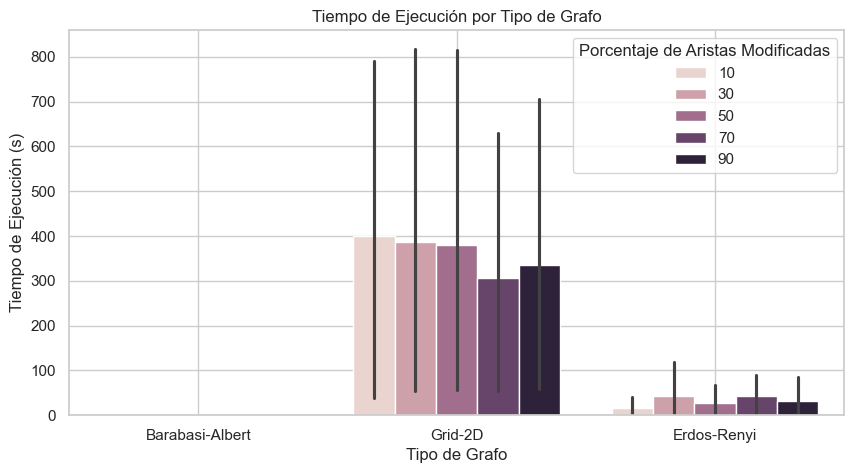

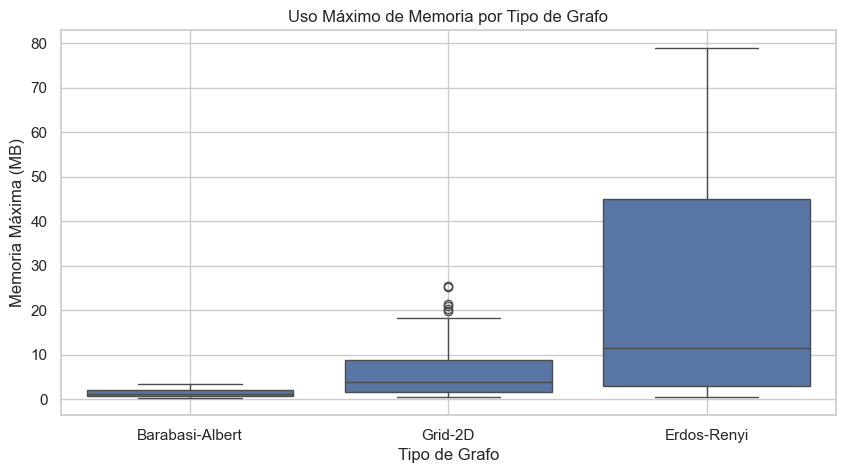

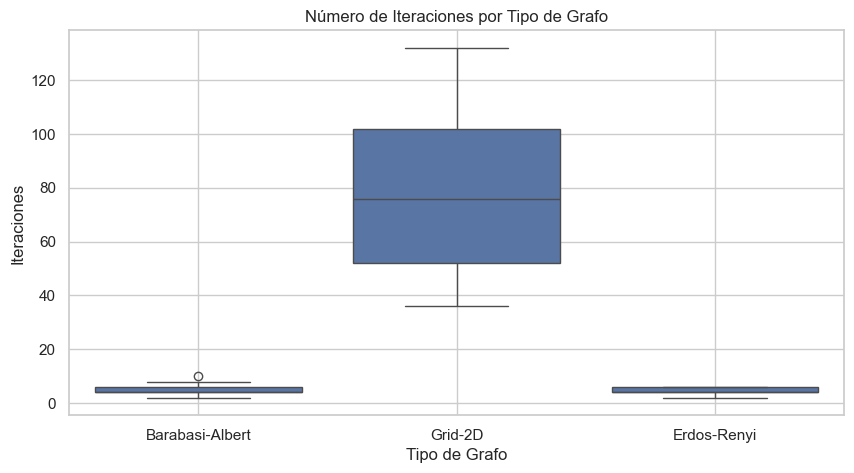

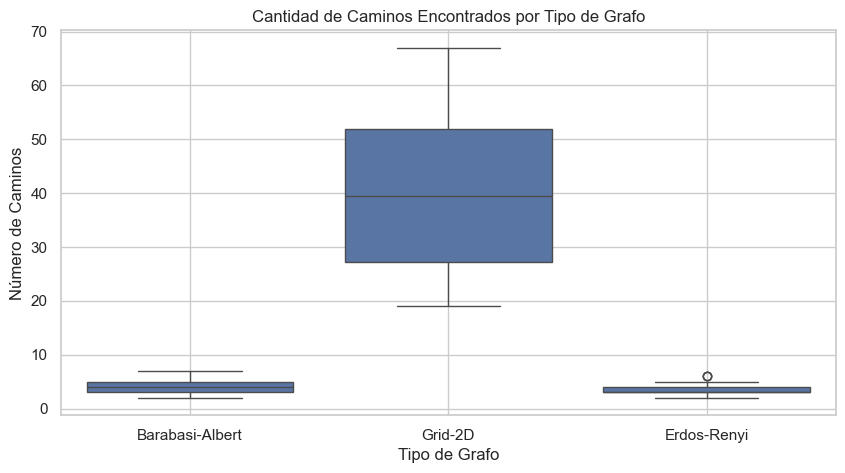

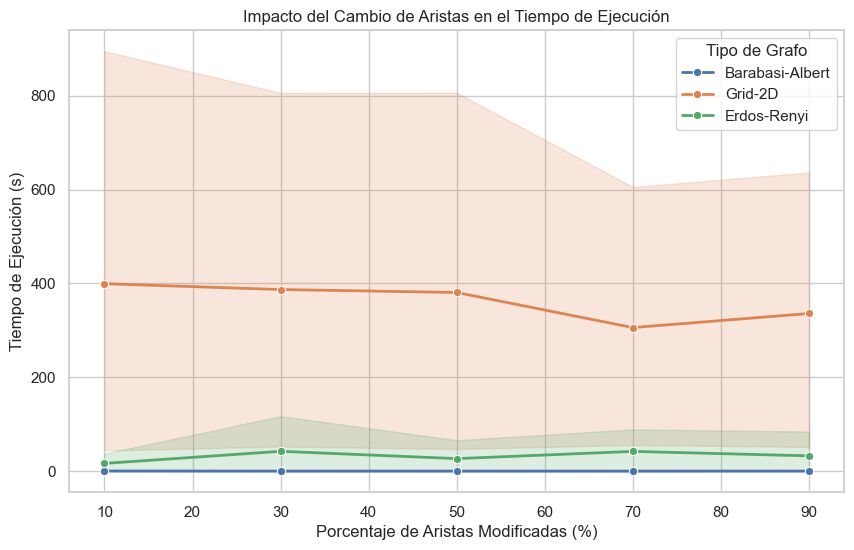

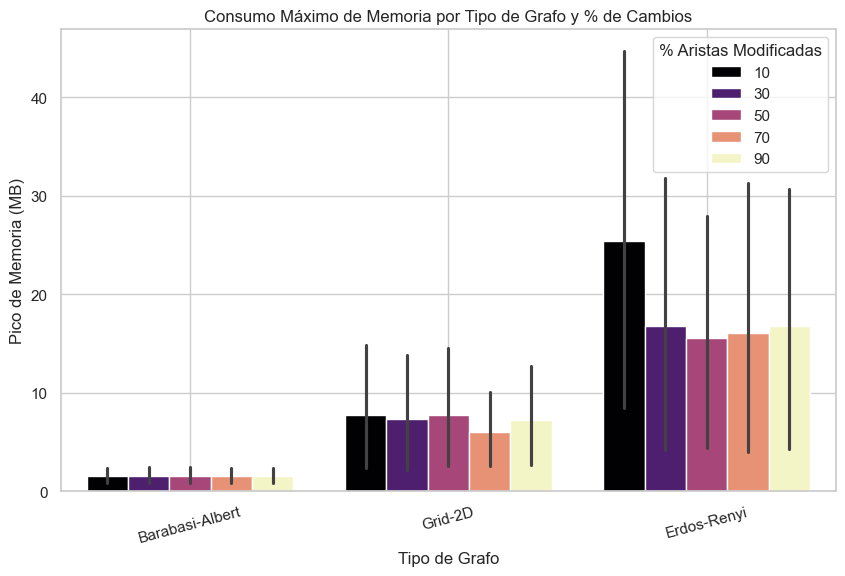

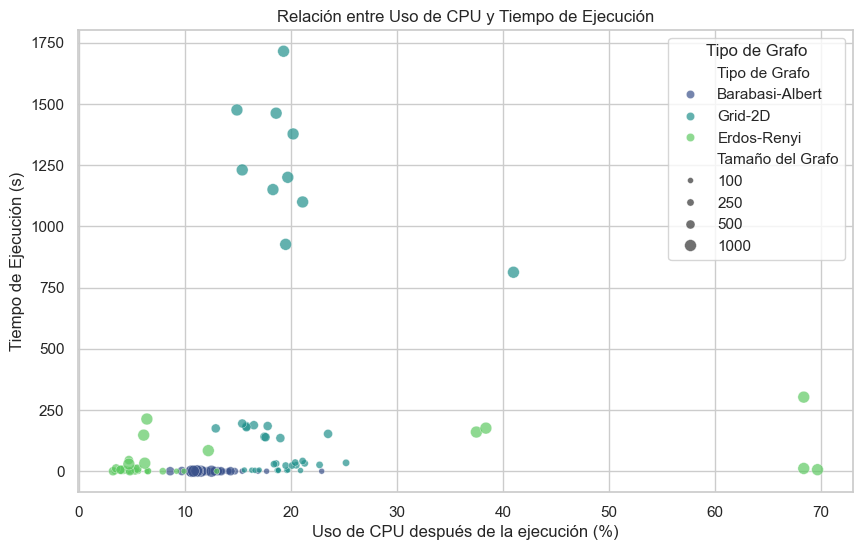

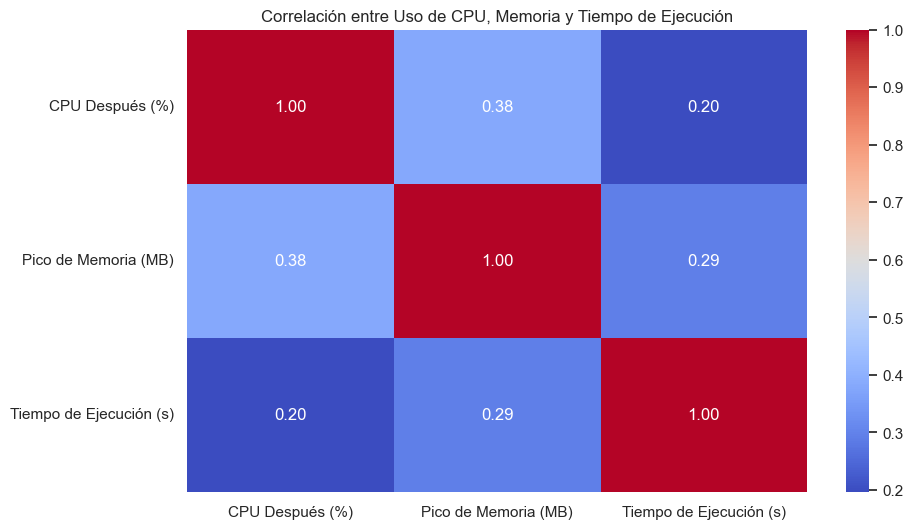


✅ Todas las gráficas han sido generadas, mostradas en pantalla y guardadas en la carpeta 'graficos/'.


In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Crear la carpeta "graficos" si no existe
output_dir = "graficos"
os.makedirs(output_dir, exist_ok=True)

# Cargar los datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar las columnas con nombres más descriptivos
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "change_percentage": "Porcentaje de Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)",
    "len_complete_path": "Cantidad de Caminos Encontrados"
}, inplace=True)

# Convertir valores a flotantes y enteros según corresponda
df["Tiempo de Ejecución (s)"] = df["Tiempo de Ejecución (s)"].astype(float)
df["Pico de Memoria (MB)"] = df["Pico de Memoria (MB)"].astype(float)
df["CPU Después (%)"] = df["CPU Después (%)"].astype(float)
df["Cantidad de Caminos Encontrados"] = df["Cantidad de Caminos Encontrados"].astype(int)
df["Memoria Actual (MB)"] = df["Memoria Actual (MB)"].astype(float)

# -------------------------------------------
# 📊 FUNCION PARA MOSTRAR Y GUARDAR GRÁFICOS
# -------------------------------------------
def mostrar_y_guardar(fig, filename):
    """Muestra el gráfico en pantalla y lo guarda en la carpeta 'graficos/'."""
    plt.show()  # Mostrar en pantalla
    fig.savefig(os.path.join(output_dir, filename))  # Guardar en la carpeta
    plt.close(fig)  # Cerrar la figura para liberar memoria

# -------------------------------------------
# 📊 GRÁFICOS COMPARATIVOS
# -------------------------------------------

# 🔹 **Gráfico de Tiempos de Ejecución**
fig = plt.figure(figsize=(10, 5))
sns.barplot(x="Tipo de Grafo", y="Tiempo de Ejecución (s)", hue="Porcentaje de Aristas Modificadas", data=df)
plt.title("Tiempo de Ejecución por Tipo de Grafo")
plt.xlabel("Tipo de Grafo")
plt.ylabel("Tiempo de Ejecución (s)")
plt.grid(True)
mostrar_y_guardar(fig, "tiempo_ejecucion_por_grafo.png")

# 🔹 **Gráfico de Uso de Memoria**
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x="Tipo de Grafo", y="Pico de Memoria (MB)", data=df)
plt.title("Uso Máximo de Memoria por Tipo de Grafo")
plt.xlabel("Tipo de Grafo")
plt.ylabel("Memoria Máxima (MB)")
plt.grid(True)
mostrar_y_guardar(fig, "uso_memoria_por_grafo.png")

# 🔹 **Gráfico de Iteraciones**
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x="Tipo de Grafo", y="Cantidad de Recalculos", data=df)
plt.title("Número de Iteraciones por Tipo de Grafo")
plt.xlabel("Tipo de Grafo")
plt.ylabel("Iteraciones")
plt.grid(True)
mostrar_y_guardar(fig, "cantidad_recalculos_por_grafo.png")

# 🔹 **Gráfico de Caminos Encontrados**
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x="Tipo de Grafo", y="Cantidad de Caminos Encontrados", data=df)
plt.title("Cantidad de Caminos Encontrados por Tipo de Grafo")
plt.xlabel("Tipo de Grafo")
plt.ylabel("Número de Caminos")
plt.grid(True)
mostrar_y_guardar(fig, "cantidad_caminos_por_grafo.png")

# 🔹 **Impacto del Porcentaje de Cambios en las Aristas**
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x="Porcentaje de Aristas Modificadas", y="Tiempo de Ejecución (s)", hue="Tipo de Grafo", data=df, marker="o", linewidth=2)
plt.title("Impacto del Cambio de Aristas en el Tiempo de Ejecución")
plt.xlabel("Porcentaje de Aristas Modificadas (%)")
plt.ylabel("Tiempo de Ejecución (s)")
plt.legend(title="Tipo de Grafo")
plt.grid(True)
mostrar_y_guardar(fig, "impacto_cambio_aristas.png")

# 🔹 **Comparación de Memoria Utilizada**
fig = plt.figure(figsize=(10, 6))
sns.barplot(x="Tipo de Grafo", y="Pico de Memoria (MB)", hue="Porcentaje de Aristas Modificadas", data=df, palette="magma")
plt.title("Consumo Máximo de Memoria por Tipo de Grafo y % de Cambios")
plt.xlabel("Tipo de Grafo")
plt.ylabel("Pico de Memoria (MB)")
plt.xticks(rotation=15)
plt.legend(title="% Aristas Modificadas")
plt.grid(True)
mostrar_y_guardar(fig, "comparacion_memoria_utilizada.png")

# 🔹 **Relación entre Uso de CPU y Tiempo de Ejecución**
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x="CPU Después (%)", y="Tiempo de Ejecución (s)", hue="Tipo de Grafo", size="Tamaño del Grafo", data=df, alpha=0.7, palette="viridis")
plt.title("Relación entre Uso de CPU y Tiempo de Ejecución")
plt.xlabel("Uso de CPU después de la ejecución (%)")
plt.ylabel("Tiempo de Ejecución (s)")
plt.legend(title="Tipo de Grafo")
plt.grid(True)
mostrar_y_guardar(fig, "relacion_cpu_tiempo.png")

# 🔹 **Comparación entre Memoria y CPU**
fig = plt.figure(figsize=(10, 6))
sns.heatmap(df[["CPU Después (%)", "Pico de Memoria (MB)", "Tiempo de Ejecución (s)"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre Uso de CPU, Memoria y Tiempo de Ejecución")
mostrar_y_guardar(fig, "correlacion_memoria_cpu.png")

print("\n✅ Todas las gráficas han sido generadas, mostradas en pantalla y guardadas en la carpeta 'graficos/'.")


In [20]:
import pandas as pd
from tabulate import tabulate

# Cargar los datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar las columnas para mayor claridad
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "change_percentage": "Porc. Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)"
}, inplace=True)

# Definir las métricas a incluir en la tabla combinada
metricas = [
    "Tiempo de Ejecución (s)",
    "Aristas Modificadas",
    "Cantidad de Recalculos",
    "Pico de Memoria (MB)",
]

# Obtener valores únicos de tipo de grafo y porcentaje de cambios
tipos_grafos = df["Tipo de Grafo"].unique()
porcentajes = sorted(df["Porc. Aristas Modificadas"].unique())

# Crear la tabla combinada
tabla_completa = []
for tipo in tipos_grafos:
    primer_fila = True
    for porc in porcentajes:
        fila = [tipo if primer_fila else "", f"{int(porc)}%"]  # Mostrar el tipo de grafo solo en la primera fila del grupo
        primer_fila = False

        # Agregar los valores promedio de cada métrica
        for metrica in metricas:
            valor = df[(df["Tipo de Grafo"] == tipo) & (df["Porc. Aristas Modificadas"] == porc)][metrica].mean()
            fila.append(f"{valor:.2f}" if not pd.isna(valor) else "-")
        
        tabla_completa.append(fila)

# Definir los encabezados de la tabla
encabezados = ["Tipo de Grafo", "Porc. Aristas Modificadas"] + metricas

# Imprimir la tabla usando tabulate
print("\nComparación Unificada por Tipo de Grafo y Porcentaje de Aristas Modificadas\n")
print(tabulate(tabla_completa, headers=encabezados, tablefmt="grid"))



Comparación Unificada por Tipo de Grafo y Porcentaje de Aristas Modificadas

+-----------------+-----------------------------+---------------------------+-----------------------+--------------------------+------------------------+
| Tipo de Grafo   | Porc. Aristas Modificadas   |   Tiempo de Ejecución (s) |   Aristas Modificadas |   Cantidad de Recalculos |   Pico de Memoria (MB) |
+=================+=============================+===========================+=======================+==========================+========================+
| Barabasi-Albert | 10%                         |                      0.36 |                  4.38 |                     5.25 |                   1.57 |
+-----------------+-----------------------------+---------------------------+-----------------------+--------------------------+------------------------+
|                 | 30%                         |                      0.21 |                  3.12 |                     5.25 |                   1.59 

In [32]:
import pandas as pd
from tabulate import tabulate

# Cargar datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar columnas para mayor claridad
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "change_percentage": "Porc. Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)"
}, inplace=True)

# Ordenar datos por Tipo de Grafo y luego por Tamaño del Grafo dentro de cada tipo
df.sort_values(by=["Tipo de Grafo", "Tamaño del Grafo"], inplace=True)

# Obtener valores únicos
tipos_grafos = df["Tipo de Grafo"].unique()
tamanos = sorted(df["Tamaño del Grafo"].unique())
porcentajes = sorted(df["Porc. Aristas Modificadas"].unique())

# Definir las métricas a comparar
metricas = [
    "Tiempo de Ejecución (s)",
    "Aristas Modificadas",
    "Cantidad de Recalculos",
    "Pico de Memoria (MB)",
]

# Generar una tabla para cada métrica
for metrica in metricas:
    print(f"\nTabla de {metrica}:")
    
    # Construcción de la tabla
    tabla = []
    for tipo in tipos_grafos:
        primer_fila = True
        for tam in tamanos:
            fila = [tipo if primer_fila else "", tam]  # Mostrar el tipo de grafo solo en la primera fila del grupo
            primer_fila = False
            for porc in porcentajes:
                valor = df[(df["Tipo de Grafo"] == tipo) & (df["Tamaño del Grafo"] == tam) & (df["Porc. Aristas Modificadas"] == porc)][metrica].mean()
                fila.append(f"{valor:.2f}" if not pd.isna(valor) else "-")
            tabla.append(fila)

    # Definir encabezados de la tabla
    encabezados = ["Tipo de Grafo", "Tamaño del Grafo"] + [f"{int(p)}%" for p in porcentajes]

    # Imprimir la tabla
    print(tabulate(tabla, headers=encabezados, tablefmt="grid"))


Tabla de Tiempo de Ejecución (s):
+-----------------+--------------------+---------+---------+---------+---------+---------+
| Tipo de Grafo   |   Tamaño del Grafo |     10% |     30% |     50% |     70% |     90% |
+=================+====================+=========+=========+=========+=========+=========+
| Barabasi-Albert |                100 |    0.17 |    0.09 |    0.1  |    0.02 |    0.04 |
+-----------------+--------------------+---------+---------+---------+---------+---------+
|                 |                250 |    0.21 |    0.09 |    0.02 |    0.13 |    0.15 |
+-----------------+--------------------+---------+---------+---------+---------+---------+
|                 |                500 |    0.14 |    0.49 |    0.59 |    0.2  |    0.07 |
+-----------------+--------------------+---------+---------+---------+---------+---------+
|                 |               1000 |    0.94 |    0.17 |    0.13 |    0.26 |    0.87 |
+-----------------+--------------------+---------+-----

In [36]:
import pandas as pd
from tabulate import tabulate

# Cargar los datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar las columnas para mayor claridad
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "change_percentage": "Porcentaje de Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)"
}, inplace=True)

# Definir las métricas a incluir en la tabla combinada
metricas = [
    "Tiempo de Ejecución (s)",
    "Aristas Modificadas",
    "Cantidad de Recalculos",
    "Pico de Memoria (MB)",
]

# Obtener valores únicos de tipo de grafo y tamaño
tipos_grafos = df["Tipo de Grafo"].unique()
tamanos = sorted(df["Tamaño del Grafo"].unique())

# Crear la tabla combinada
tabla_completa = []
for tipo in tipos_grafos:
    primer_fila = True
    for tam in tamanos:
        fila = [tipo if primer_fila else "", tam]  # Mostrar el tipo de grafo solo en la primera fila del grupo
        primer_fila = False

        # Agregar los valores promedio de cada métrica
        for metrica in metricas:
            valor = df[(df["Tipo de Grafo"] == tipo) & (df["Tamaño del Grafo"] == tam)][metrica].mean()
            fila.append(f"{valor:.2f}" if not pd.isna(valor) else "-")
        
        tabla_completa.append(fila)

# Definir los encabezados de la tabla
encabezados = ["Tipo de Grafo", "Tamaño del Grafo"] + metricas

# Imprimir la tabla usando tabulate
print("\nComparación Unificada por Tipo de Grafo y Tamaño\n")
print(tabulate(tabla_completa, headers=encabezados, tablefmt="grid"))



Comparación Unificada por Tipo de Grafo y Tamaño

+-----------------+--------------------+---------------------------+-----------------------+--------------------------+------------------------+
| Tipo de Grafo   |   Tamaño del Grafo |   Tiempo de Ejecución (s) |   Aristas Modificadas |   Cantidad de Recalculos |   Pico de Memoria (MB) |
+=================+====================+===========================+=======================+==========================+========================+
| Barabasi-Albert |                100 |                      0.08 |                   4.4 |                      5.4 |                   0.41 |
+-----------------+--------------------+---------------------------+-----------------------+--------------------------+------------------------+
|                 |                250 |                      0.12 |                   2.8 |                      4.2 |                   0.85 |
+-----------------+--------------------+---------------------------+-----------

In [24]:
import pandas as pd
from tabulate import tabulate

# Cargar datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar columnas para mayor claridad
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "len_start_path" : "Longtud del camino inicial",
    "len_complete_path": "Longtud del camino final",
    "change_percentage": "Porc. Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)"
}, inplace=True)

# Ordenar datos por Tipo de Grafo y luego por Tamaño del Grafo dentro de cada tipo
df.sort_values(by=["Tipo de Grafo", "Tamaño del Grafo"], inplace=True)

# Obtener valores únicos
tipos_grafos = df["Tipo de Grafo"].unique()
tamanos = sorted(df["Tamaño del Grafo"].unique())
porcentajes = sorted(df["Porc. Aristas Modificadas"].unique())

# Definir las métricas a comparar
metricas = [
    "Tiempo de Ejecución (s)",
    "Aristas Modificadas",
    "Cantidad de Recalculos",
    "Memoria Actual (MB)",
    "Pico de Memoria (MB)",
    "CPU Antes (%)",
    "CPU Después (%)"
]

### 1. COMPARACIÓN POR TIPO DE GRAFO Y TAMAÑO ###
for metrica in metricas:
    print(f"\nComparación de {metrica} por Tipo de Grafo y Tamaño:\n")
    tabla = []
    for tipo in tipos_grafos:
        primer_fila = True
        for tam in tamanos:
            fila = [tipo if primer_fila else "", tam]  # Mostrar el tipo de grafo solo en la primera fila del grupo
            primer_fila = False
            valor = df[(df["Tipo de Grafo"] == tipo) & (df["Tamaño del Grafo"] == tam)][metrica].mean()
            fila.append(f"{valor:.2f}" if not pd.isna(valor) else "-")
            tabla.append(fila)

    encabezados = ["Tipo de Grafo", "Tamaño del Grafo", metrica]
    print(tabulate(tabla, headers=encabezados, tablefmt="grid"))


### 2. COMPARACIÓN POR PORCENTAJE DE ARISTAS MODIFICADAS ###
for metrica in metricas:
    print(f"\nComparación de {metrica} por Porcentaje de Aristas Modificadas:\n")
    tabla = []
    for tipo in tipos_grafos:
        primer_fila = True
        for porc in porcentajes:
            fila = [tipo if primer_fila else "", f"{int(porc)}%"]  # Mostrar el tipo de grafo solo en la primera fila del grupo
            primer_fila = False
            valor = df[(df["Tipo de Grafo"] == tipo) & (df["Porc. Aristas Modificadas"] == porc)][metrica].mean()
            fila.append(f"{valor:.2f}" if not pd.isna(valor) else "-")
            tabla.append(fila)

    encabezados = ["Tipo de Grafo", "Porc. Aristas Modificadas", metrica]
    print(tabulate(tabla, headers=encabezados, tablefmt="grid"))


### 3. RESUMEN COMPARATIVO GENERAL ###
print("\nResumen Comparativo General (Promedio de Todas las Métricas por Tipo de Grafo):\n")

# Excluir la columna "test_id" antes de calcular los promedios
resumen = df.drop(columns=["test_id"], errors="ignore").groupby("Tipo de Grafo").mean(numeric_only=True).reset_index()

# Imprimir la tabla sin "test_id"
print(tabulate(resumen, headers="keys", tablefmt="grid", showindex=False))



Comparación de Tiempo de Ejecución (s) por Tipo de Grafo y Tamaño:

+-----------------+--------------------+---------------------------+
| Tipo de Grafo   |   Tamaño del Grafo |   Tiempo de Ejecución (s) |
+=================+====================+===========================+
| Barabasi-Albert |                100 |                      0.08 |
+-----------------+--------------------+---------------------------+
|                 |                250 |                      0.12 |
+-----------------+--------------------+---------------------------+
|                 |                500 |                      0.29 |
+-----------------+--------------------+---------------------------+
|                 |               1000 |                      0.48 |
+-----------------+--------------------+---------------------------+
| Erdos-Renyi     |                100 |                      0.24 |
+-----------------+--------------------+---------------------------+
|                 |               

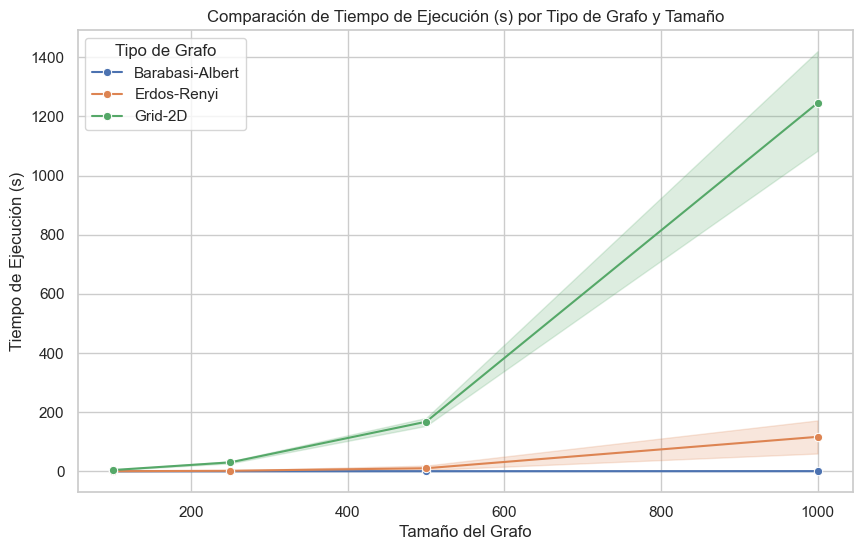

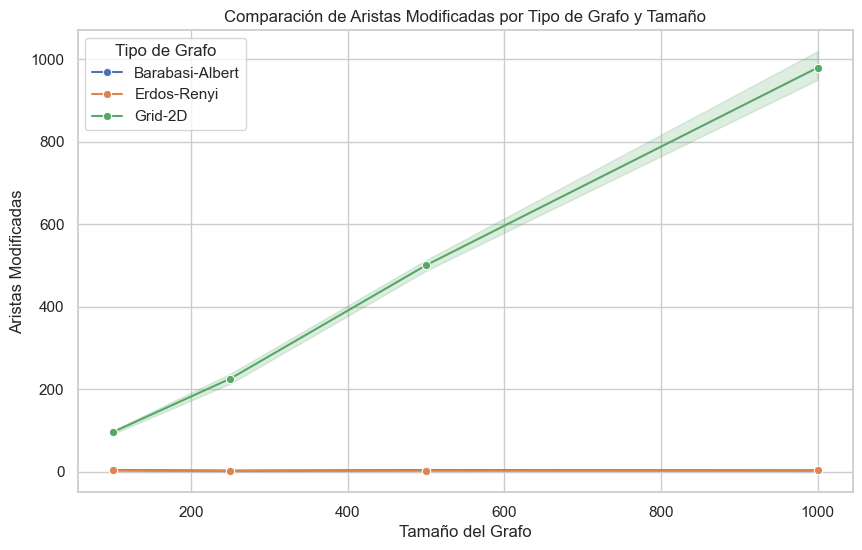

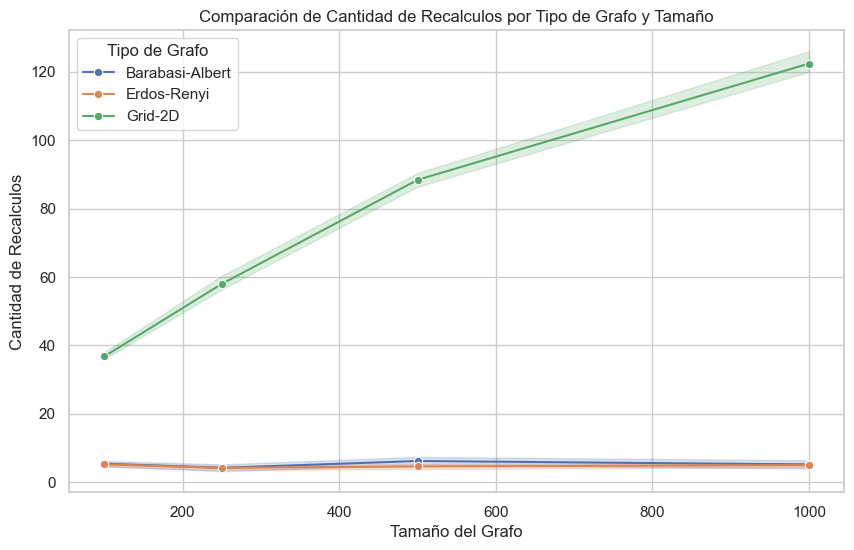

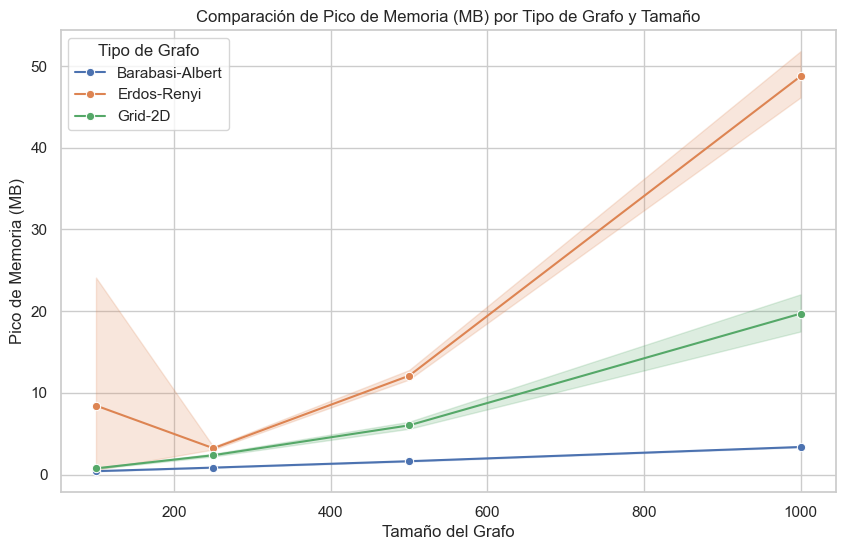

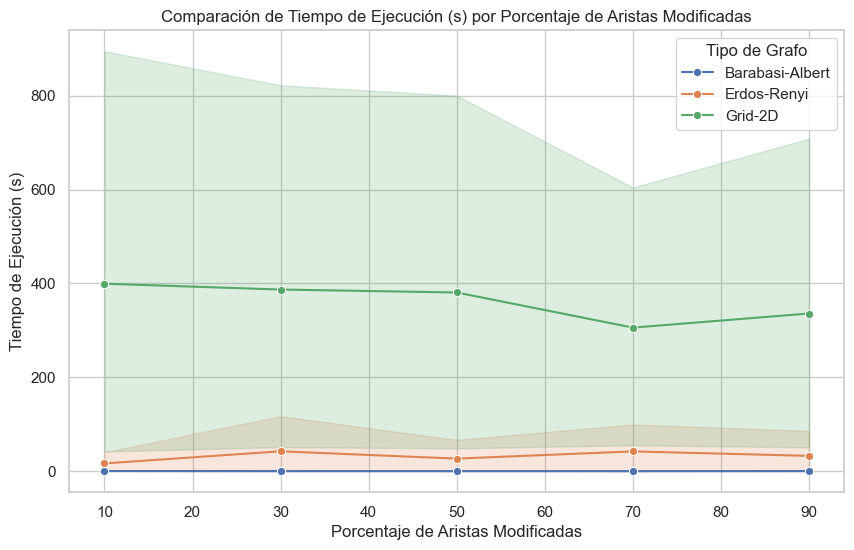

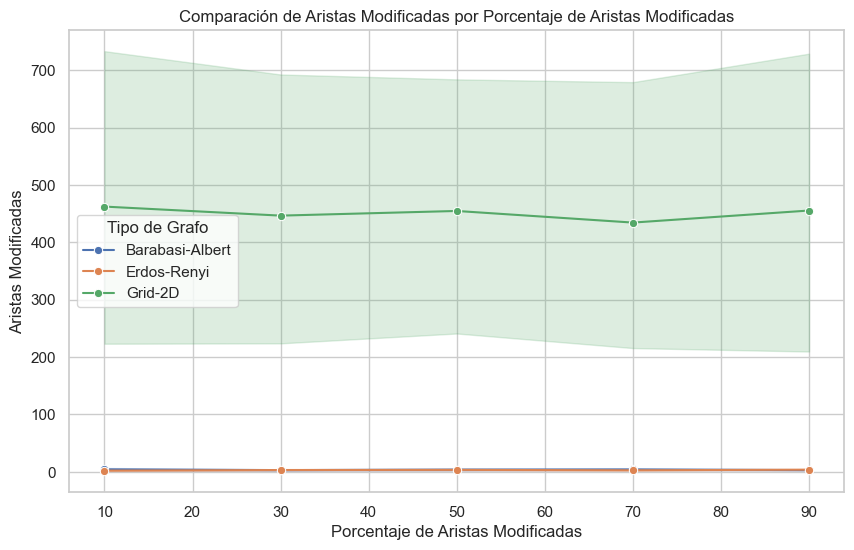

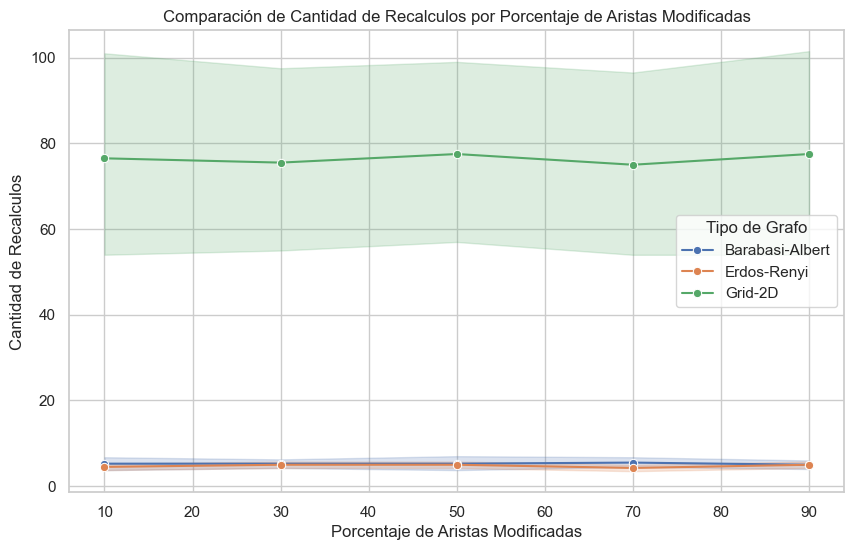

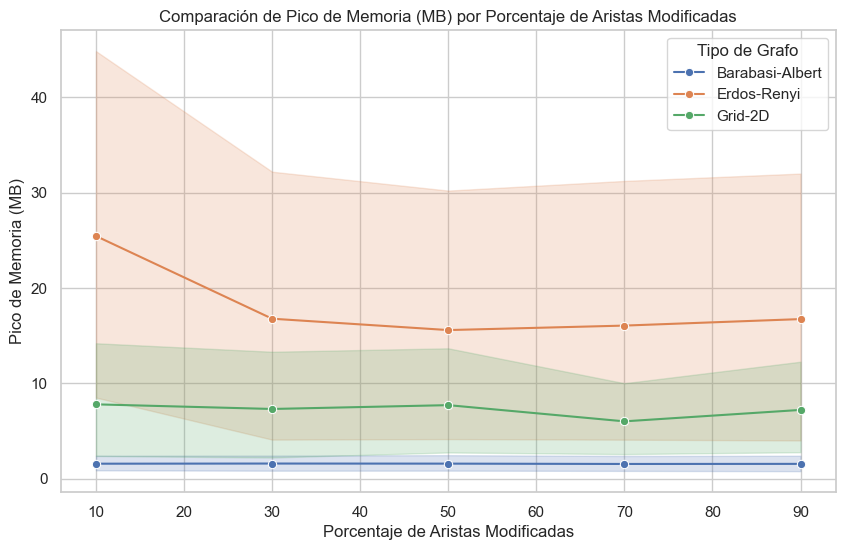

<Figure size 1200x800 with 0 Axes>

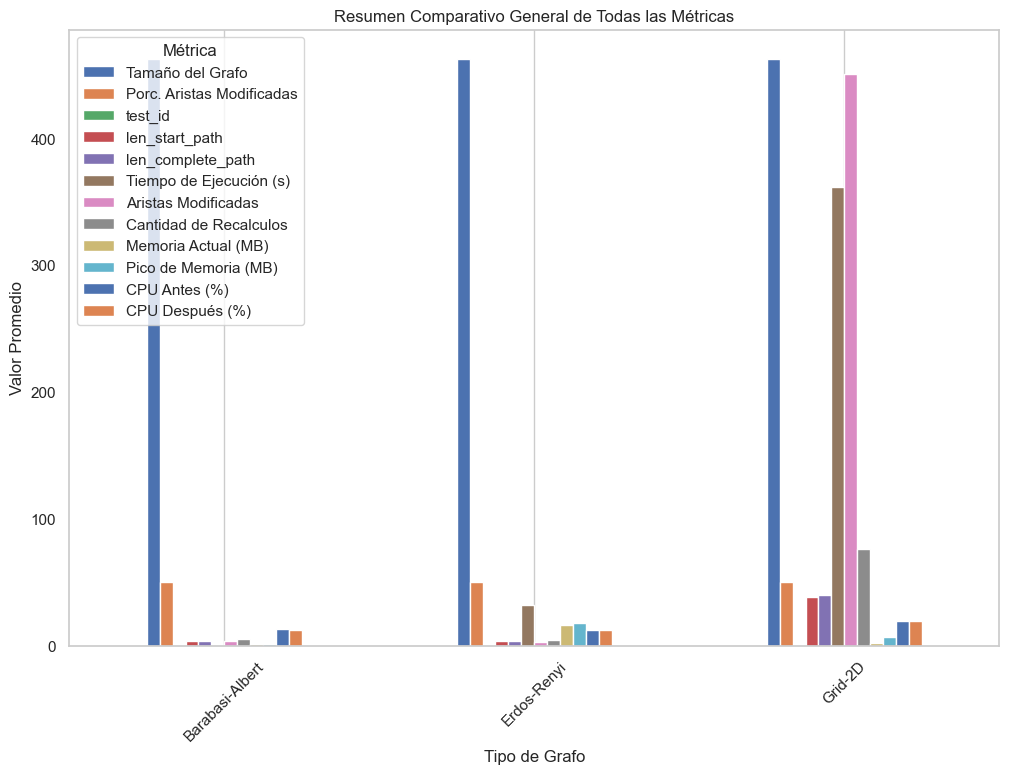

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos del CSV
csv_file = "stress_test_results.csv"
df = pd.read_csv(csv_file)

# Renombrar columnas para mayor claridad
df.rename(columns={
    "graph_type": "Tipo de Grafo",
    "graph_size": "Tamaño del Grafo",
    "change_percentage": "Porc. Aristas Modificadas",
    "exec_time": "Tiempo de Ejecución (s)",
    "modified_edges_count": "Aristas Modificadas",
    "recalculate_count": "Cantidad de Recalculos",
    "current_mem": "Memoria Actual (MB)",
    "peak_mem": "Pico de Memoria (MB)",
    "cpu_before": "CPU Antes (%)",
    "cpu_after": "CPU Después (%)"
}, inplace=True)

# Ordenar datos por Tipo de Grafo y luego por Tamaño del Grafo dentro de cada tipo
df.sort_values(by=["Tipo de Grafo", "Tamaño del Grafo"], inplace=True)

# Obtener valores únicos
tipos_grafos = df["Tipo de Grafo"].unique()
tamanos = sorted(df["Tamaño del Grafo"].unique())
porcentajes = sorted(df["Porc. Aristas Modificadas"].unique())

# Definir las métricas a comparar
metricas = [
    "Tiempo de Ejecución (s)",
    "Aristas Modificadas",
    "Cantidad de Recalculos",
    "Pico de Memoria (MB)",
]

# Configuración de estilo de gráficos
sns.set(style="whitegrid")

### 1. COMPARACIÓN POR TIPO DE GRAFO Y TAMAÑO ###
for metrica in metricas:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="Tamaño del Grafo", y=metrica, hue="Tipo de Grafo", marker="o")
    plt.title(f"Comparación de {metrica} por Tipo de Grafo y Tamaño")
    plt.xlabel("Tamaño del Grafo")
    plt.ylabel(metrica)
    plt.legend(title="Tipo de Grafo")
    plt.grid(True)
    plt.savefig(f"graficos/{metrica}_por_tamano.png", dpi=300)
    plt.show()

### 2. COMPARACIÓN POR PORCENTAJE DE ARISTAS MODIFICADAS ###
for metrica in metricas:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="Porc. Aristas Modificadas", y=metrica, hue="Tipo de Grafo", marker="o")
    plt.title(f"Comparación de {metrica} por Porcentaje de Aristas Modificadas")
    plt.xlabel("Porcentaje de Aristas Modificadas")
    plt.ylabel(metrica)
    plt.legend(title="Tipo de Grafo")
    plt.grid(True)
    plt.savefig(f"graficos/{metrica}_por_porcentaje.png", dpi=300)
    plt.show()

### 3. RESUMEN COMPARATIVO GENERAL ###
df_resumen = df.groupby("Tipo de Grafo").mean(numeric_only=True).reset_index()

plt.figure(figsize=(12, 8))
df_resumen.set_index("Tipo de Grafo").plot(kind="bar", figsize=(12, 8))
plt.title("Resumen Comparativo General de Todas las Métricas")
plt.xlabel("Tipo de Grafo")
plt.ylabel("Valor Promedio")
plt.xticks(rotation=45)
plt.legend(title="Métrica")
plt.grid(axis="y")
plt.savefig("graficos/resumen_general.png", dpi=300)
plt.show()

In [ ]:
import csv
import time
import random
import networkx as nx
import tracemalloc
import multiprocessing
import psutil
import pandas as pd
from collections import defaultdict



# Definir funciones en lugar de lambdas
def generate_barabasi_albert(n):
    return nx.barabasi_albert_graph(n, m=3)

def generate_grid_2d(n):
    return nx.grid_2d_graph(int(n**0.5), int(n**0.5))

def generate_erdos_renyi(n):
    return nx.erdos_renyi_graph(n, p=0.05, directed=True)

# Lista de tipos de grafos con funciones definidas
graph_types = [
    ("Barabasi-Albert", generate_barabasi_albert),
    ("Grid-2D", generate_grid_2d),
    ("Erdos-Renyi", generate_erdos_renyi)
]

graph_sizes = [100]  # Tamaños de grafos a probar
change_percentages = [0.1, 0.3, 0.5, 0.7, 0.9]  # Porcentajes de aristas modificadas
num_tests = 3  # Número de repeticiones por caso

# Ruta del archivo CSV
csv_file = "stress_test_results.csv"

# -------------------------------------------
# FUNCIÓN QUE EJECUTA UNA PRUEBA INDIVIDUAL
# -------------------------------------------
def run_test(graph_name, graph_generator, n, change_pct, test_id):
    print(f"\nEjecutando prueba: {graph_name} con {n} nodos y {int(change_pct * 100)}% de aristas modificadas (Test {test_id})...")

    # Iniciar monitoreo de memoria
    tracemalloc.start()

    # Generar el grafo
    G = graph_generator(n)
    dynamic_graph = DynamicGraph()

    # Convertir nodos `(x, y)` en `Grid-2D` a strings "x,y"
    if graph_name == "Grid-2D":
        G = nx.relabel_nodes(G, lambda node: f"{node[0]},{node[1]}")

    # Agregar aristas con pesos aleatorios
    for u, v in G.edges():
        dynamic_graph.add_edge(str(u), str(v), time=random.uniform(1, 10),
                               distance=random.uniform(5, 50), safety=random.uniform(1, 10))

    # Ajustar `source` y `target`
    if graph_name == "Grid-2D":
        source, target = f"0,0", f"{int(n**0.5)-1},{int(n**0.5)-1}"
    else:
        source, target = "0", str(n - 1)

    # Instanciar el algoritmo DynamicTMDA
    edge_updater = DynamicEdgeUpdater(dynamic_graph)
    algorithm = DynamicTMDA(dynamic_graph, dimensions=[("time", 1), ("distance", 1), ("safety", 1)],
                            source=source, target=target, edge_updater=edge_updater)

    # Medir uso de CPU antes de ejecutar
    cpu_before = psutil.cpu_percent(interval=1)

    # Ejecutar el algoritmo
    start_time = time.time()
    paths_after = list(algorithm.navigate())
    exec_time = time.time() - start_time

    # Medir uso de CPU después de ejecutar
    cpu_after = psutil.cpu_percent(interval=1)

    # Medir memoria utilizada
    current_mem, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Guardar resultados en el CSV
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            graph_name, n, int(change_pct * 100), test_id, algorithm.start_path['path'], algorithm.start_path['cost'],
            algorithm.start_path['reduced_cost'], len(algorithm.start_path['path']),
            algorithm.complete_path['path'], algorithm.complete_path['cost'], algorithm.complete_path['reduced_cost'],
            len(algorithm.complete_path['path']), exec_time, algorithm.modified_edges_count,
            algorithm.recalculate_count, current_mem / (1024**2), peak_mem / (1024**2), cpu_before, cpu_after
        ])

    print(f"\nPrueba {test_id} finalizada: {graph_name} con {n} nodos y {int(change_pct * 100)}% cambios.")


# -------------------------------------------
# PARALELIZAR PRUEBAS CON `multiprocessing`
# -------------------------------------------
if __name__ == "__main__":
    # Número de procesos en paralelo (máximo la cantidad de núcleos disponibles)
    num_workers = min(multiprocessing.cpu_count(), 8)  # Usa hasta 8 procesos en paralelo

    # Crear una lista de tareas para cada combinación de parámetros
    test_cases = [
        (graph_name, graph_generator, n, change_pct, test_id)
        for graph_name, graph_generator in graph_types
        for n in graph_sizes
        for change_pct in change_percentages
        for test_id in range(num_tests)
    ]

    # Crear un Pool de procesos para ejecutar pruebas en paralelo
    with multiprocessing.Pool(processes=num_workers) as pool:
        pool.starmap(run_test, test_cases)

    print("\nTODAS LAS PRUEBAS FINALIZADAS. Los resultados están en 'stress_test_results.csv'.")

